In [ ]:
## RAP Composite Maps
## Author: Katie McKeown

## These plots create composite maps for 250, 500, 850 hPa and surface data.
    ## 250: winds and geopotential height
    ## 500: omega inset, geopotential height, voriticty
    ## 850: zoomed in relative humidity, temperature and geopotential height
    ## Surface: temperature and pressure

## Cleaned up 9 May 2024 

In [1]:
## Import all modules
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pygrib
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
import cfgrib
import cartopy
import scipy

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
from matplotlib.patches import Rectangle

In [2]:
## We'll start with our gulf files
p = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Gulf_Data/RAP Data/rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datag = xr.open_mfdataset(p, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 500.0}},
                         combine = 'nested', concat_dim = 'valid_time').load()

datag

<xarray.Dataset> Size: 53MB
Dimensions:        (valid_time: 12, y: 337, x: 451)
Coordinates:
    time           (valid_time) datetime64[ns] 96B 2017-06-10T15:00:00 ... 20...
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 500.0
    latitude       (y, x) float64 1MB 16.28 16.31 16.34 ... 55.54 55.51 55.48
    longitude      (y, x) float64 1MB 233.9 234.0 234.1 ... 302.3 302.4 302.6
  * valid_time     (valid_time) datetime64[ns] 96B 2017-06-10T15:00:00 ... 20...
Dimensions without coordinates: y, x
Data variables:
    gh             (valid_time, y, x) float32 7MB 5.889e+03 ... 5.447e+03
    t              (valid_time, y, x) float32 7MB 269.6 269.6 ... 248.3 248.3
    r              (valid_time, y, x) float32 7MB 53.45 52.95 ... 71.89 72.76
    w              (valid_time, y, x) float32 7MB 0.1441 0.1129 ... -0.06547
    u              (valid_time, y, x) float32 7MB 2.473 2.348 ... -11.01 -11.33
    v              (valid_time, y, x) float32 7MB 3.141 3.016 ... 0.9357 1.248
    absv           (valid_time, y, x) float32 7MB 1.062e-05 ... 0.000154
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-11-20T12:10 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
u = datag.u.metpy.quantify().metpy.convert_units('knot')
v = datag.v.metpy.quantify().metpy.convert_units('knot')
lons, lats = datag.longitude.values, datag.latitude.values
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

vor_500g = mpcalc.vorticity(u, v, dx=dx[np.newaxis, :,:], dy=dy[np.newaxis, :, :])
vor_500g = vor_500g.metpy.convert_units('1/s').data.magnitude
vor_500g[vor_500g < 1e-5] = np.nan

dims = ('valid_time', 'y', 'x')
vor_500g_da = xr.DataArray(vor_500g, dims=dims, coords  = {
    'valid_time': datag['valid_time'],
    'y' : datag['y'],
    'x' : datag['x']
})

datag['vorticity'] = vor_500g_da
dsg = datag.mean(dim='valid_time', keep_attrs = True).load()
vor_500g

array([[[           nan,            nan,            nan, ...,
         2.79253859e-05, 3.02557430e-05, 4.65482930e-05],
        [           nan,            nan,            nan, ...,
         1.86150688e-05, 2.32686958e-05, 2.09439317e-05],
        [           nan,            nan,            nan, ...,
                    nan, 2.09359773e-05, 2.55893373e-05],
        ...,
        [3.74658329e-05, 3.74742657e-05, 4.55272628e-05, ...,
         1.90364503e-05,            nan,            nan],
        [4.01790889e-05, 4.55636511e-05, 5.09370216e-05, ...,
         1.36162463e-05,            nan,            nan],
        [4.82725329e-05, 5.90107231e-05, 5.09955116e-05, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
         1.39616277e-05, 2.55978419e-05,            nan],
        [           nan,            nan,            nan, ...,
                    nan, 1.16359801e-05, 2.09418783e-05],
        [           nan, 

In [2]:
## This is a definition to get high and low pressure systems, as creaged by unidata
## This was modified by Katie McKeown and Karl Schnieder

def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        txt = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        txt.set_clip_box(ax.bbox)
        txt2 = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(int(data[mxy[i], mxx[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        txt2.set_clip_box(ax.bbox)

In [5]:
## Get our u and v data
u = dsg.u.metpy.quantify().metpy.convert_units('knot')
v = dsg.v.metpy.quantify().metpy.convert_units('knot')
w = dsg.w.metpy.quantify()

/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_79903/3132989527.py:23: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter, minimum_filter
/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_79903/3132989527.py:23: DeprecationWarning: Please import `minimum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter, minimum_filter


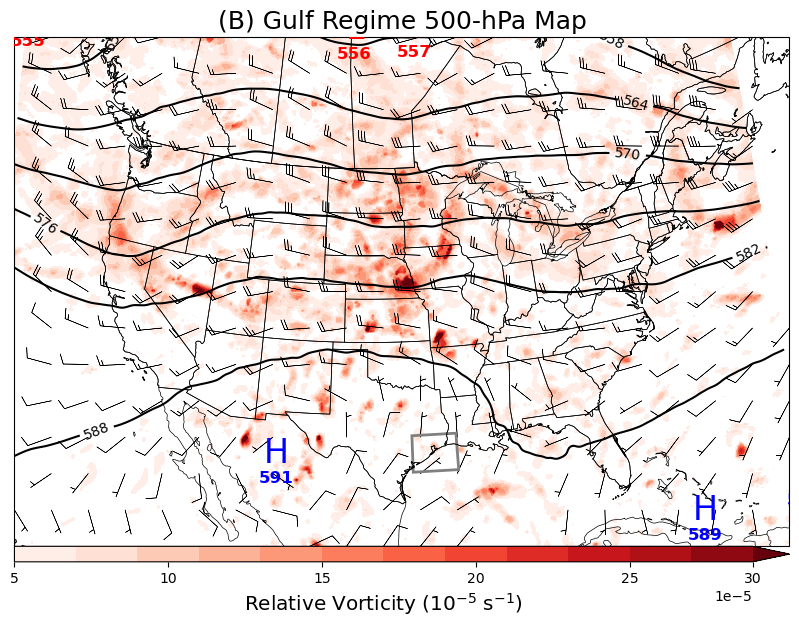

In [10]:
## Make a 500 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
##fig = plt.figure(figsize = (5,5))
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([235., 290., 20., 55.])
##ax.set_extent([-91., -108., 25., 36.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())


lons, lats = dsg.longitude.values, dsg.latitude.values

## Get the heights and smooth so that it's not wobbly
gh = (dsg.gh.values)/10.  ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
cs = ax.contour(lons, lats, gh, levels = np.arange(420, 660, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)

## Calculate and plot relative voriticty
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
vor_500g = dsg['vorticity'].values
cfv = ax.contourf(lons, lats, vor_500g, cmap = 'Reds', levels = np.arange(5e-5, 3.01e-4, 20e-6), vmin = 5e-5, vmax = 3e-4, extend = "max",
                 transform = ccrs.PlateCarree())

##(0, 1.01e-4, 1e-6), vmin = 0, vmax = 1e-4
## Calculate and plot vertical vorticity

##w = dsg.w.metpy.quantify()
##cfr = ax.contourf(lons, lats, w.data.magnitude, cmap = 'RdBu', levels = np.arange(-1, 1, 0.01), vmin = -1.0, vmax = 1.01,
    ##              transform = ccrs.PlateCarree())
cb2=fig.colorbar(cfv, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_ticks(np.arange(5e-5, 3.01e-4, 5e-5))
cb2.set_label(r'Relative Vorticity ($10^{-5}$ s$^{-1}$)', size='x-large') 
##cb2.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x * 1e5)))
##cb2.formatter = ticker.ScalarFormatter(useMathText=True)
cb2.formatter.set_scientific(True)
cb2.formatter.set_powerlimits((-5,-5))
cb2.update_ticks()
    
## Create the colorbar for omega
##cb2=fig.colorbar(cfr, ax=ax, orientation='horizontal', pad=0, aspect=50)
##cb2.set_label(r'Omega Pa/s', size='x-large')

## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude, v.data.magnitude, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

## for high/low pressure systems
plot_maxmin_points(lons, lats, gh, extrema = 'max', nsize = 50, symbol = 'H', color = 'b',
                   plotValue=False, transform= ccrs.PlateCarree())

plot_maxmin_points(lons, lats, gh, extrema = 'min', nsize = 50, symbol = 'L', color = 'r',
                   plotValue=False, transform= ccrs.PlateCarree())

ax.add_patch(rect)

ax.set_title('(B) Gulf Regime 500-hPa Map',fontsize = 18)

plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Gulf_500_composite_vort', dpi=300)
##plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Gulf_500_composite_w', dpi=300)

In [3]:
## Repeat everything for Land Data
p2 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Land_Data/RAP Files/rap_130*.grb2'


## WE want to open our data. This is for the 500 geopotential height level
datal = xr.open_mfdataset(p2, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 500.0}},
                         combine = 'nested', concat_dim = 'valid_time').load()

print(datal)

<xarray.Dataset> Size: 53MB
Dimensions:        (valid_time: 12, y: 337, x: 451)
Coordinates:
    time           (valid_time) datetime64[ns] 96B 2017-06-14T15:00:00 ... 20...
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 500.0
    latitude       (y, x) float64 1MB 16.28 16.31 16.34 ... 55.54 55.51 55.48
    longitude      (y, x) float64 1MB 233.9 234.0 234.1 ... 302.3 302.4 302.6
  * valid_time     (valid_time) datetime64[ns] 96B 2017-06-14T15:00:00 ... 20...
Dimensions without coordinates: y, x
Data variables:
    gh             (valid_time, y, x) float32 7MB 5.872e+03 ... 5.403e+03
    t              (valid_time, y, x) float32 7MB 268.9 268.9 ... 247.3 247.4
    r              (valid_time, y, x) float32 7MB 7.418 7.293 ... 27.27 27.77
    w              (valid_time, y, x) float32 7MB 0.069 0.069 ... -0.2374
    u              (valid_time, y, x) float32 7MB -6.629 -6.692 ... 15.74 15.86
    v              (valid_time, y, x) float32 7MB -1.065 -1.002 ... 1

In [4]:
u = datal.u.metpy.quantify().metpy.convert_units('knot')
v = datal.v.metpy.quantify().metpy.convert_units('knot')
lons, lats = datal.longitude.values, datal.latitude.values
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

vor_500l = mpcalc.vorticity(u, v, dx=dx[np.newaxis, :,:], dy=dy[np.newaxis, :, :])
vor_500l = vor_500l.metpy.convert_units('1/s').data.magnitude
vor_500l[vor_500l < 1e-5] = np.nan

dims = ('valid_time', 'y', 'x')
vor_500l_da = xr.DataArray(vor_500l, dims=dims, coords  = {
    'valid_time': datal['valid_time'],
    'y' : datal['y'],
    'x' : datal['x']
})

datal['vorticity'] = vor_500l_da
dsl = datal.mean(dim='valid_time', keep_attrs = True).load()
vor_500l


array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[1.16675177e-05,            nan,            nan, ...,
         1.86196972e-05, 1.62947099e-05, 2.79317452e-05],
        [1.16639595e-05,            nan,            nan, ...,
         2.09397098e-05, 2.32669763e-05, 2.55957399e-05],
        [1.16605311e-05, 

In [5]:
## Get our u and v data
u = dsl.u.metpy.quantify().metpy.convert_units('knot')
v = dsl.v.metpy.quantify().metpy.convert_units('knot')
w = dsl.w.metpy.quantify()

/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_79903/3132989527.py:23: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter, minimum_filter
/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_79903/3132989527.py:23: DeprecationWarning: Please import `minimum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter, minimum_filter


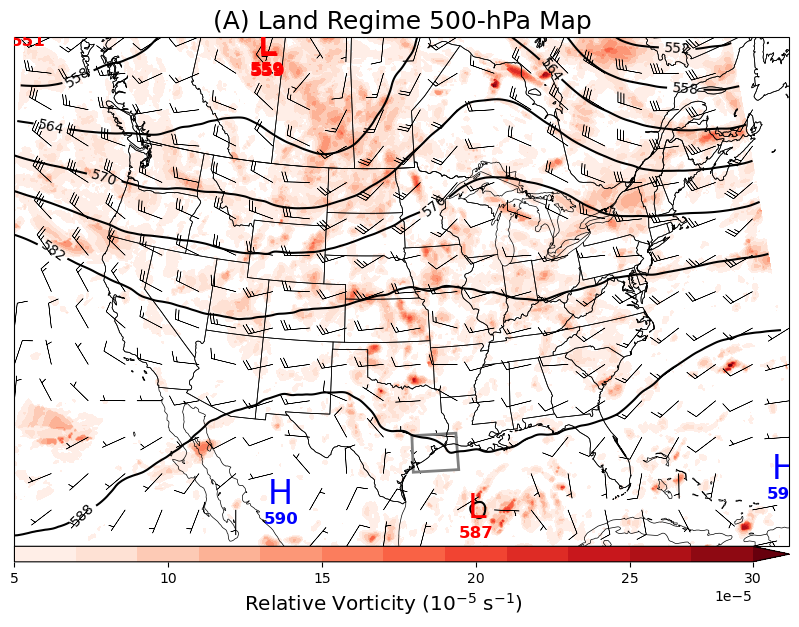

In [14]:
## Make a 500 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
##fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([235., 290., 20., 55.])
##ax.set_extent([-91., -108., 25., 36.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())



lons, lats = dsl.longitude.values, dsl.latitude.values

## Get the heights and smooth so that it's not wobbly
##gh = mpcalc.smooth_gaussian((dsl.gh.values)/10. , 1) ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
gh = (dsl.gh.values)/10.
cs = ax.contour(lons, lats, gh, levels = np.arange(420, 660, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)


## Calculate and plot vertical vorticity

##w = dsl.w.metpy.quantify()
##cfr = ax.contourf(lons, lats, w.data.magnitude, cmap = 'RdBu', levels = np.arange(-1, 1, 0.01), vmin = -1.0, vmax = 1.1,
                 ## transform = ccrs.PlateCarree())

## Create the colorbar for relative vorticity
##cb2=fig.colorbar(cfr, ax=ax, orientation='horizontal', pad=0, aspect=50)
##cb2.set_label(r'Omega Pa/s', size='x-large')
## Calculate and plot relative voriticty
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
vor_500l = dsl['vorticity'].values
cfv = ax.contourf(lons, lats, vor_500l, cmap = 'Reds', levels = np.arange(5e-5, 3.01e-4, 20e-6), vmin = 5e-5, vmax = 3e-4, extend = "max",
                 transform = ccrs.PlateCarree())

##(0, 1.01e-4, 1e-6), vmin = 0, vmax = 1e-4
## Calculate and plot vertical vorticity

##w = dsg.w.metpy.quantify()
##cfr = ax.contourf(lons, lats, w.data.magnitude, cmap = 'RdBu', levels = np.arange(-1, 1, 0.01), vmin = -1.0, vmax = 1.01,
    ##              transform = ccrs.PlateCarree())
cb2=fig.colorbar(cfv, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_ticks(np.arange(5e-5, 3.01e-4, 5e-5))
cb2.set_label(r'Relative Vorticity ($10^{-5}$ s$^{-1}$)', size='x-large') 
##cb2.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x * 1e5)))
##cb2.formatter = ticker.ScalarFormatter(useMathText=True)
cb2.formatter.set_scientific(True)
cb2.formatter.set_powerlimits((-5,-5))
cb2.update_ticks()


## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude, v.data.magnitude, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

## for high/low pressure systems
plot_maxmin_points(lons, lats, gh, extrema = 'max', nsize = 50, symbol = 'H', color = 'b',
                   plotValue=False, transform= ccrs.PlateCarree())

plot_maxmin_points(lons, lats, gh, extrema = 'min', nsize = 50, symbol = 'L', color = 'r',
                   plotValue=False, transform= ccrs.PlateCarree())

ax.add_patch(rect)

ax.set_title('(A) Land Regime 500-hPa Map',fontsize = 18)
##plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Land_500_composite_w', dpi = 300)
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Land_500_composite', dpi = 300)

In [41]:
## Let's split up the domain wide into the two regimes 
## We'll start with our gulf files
p4 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/Rap Data/Mode 1/rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datab1 = xr.open_mfdataset(p4, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 500.0}},
                         combine = 'nested', concat_dim = 'valid_time').load()

In [42]:
u = datab1.u.metpy.quantify().metpy.convert_units('knot')
v = datab1.v.metpy.quantify().metpy.convert_units('knot')
lons, lats = datab1.longitude.values, datab1.latitude.values
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

vor_500b1 = mpcalc.vorticity(u, v, dx=dx[np.newaxis, :,:], dy=dy[np.newaxis, :, :])
vor_500b1 = vor_500b1.metpy.convert_units('1/s').data.magnitude
vor_500b1[vor_500b1 < 1e-5] = np.nan

dims = ('valid_time', 'y', 'x')
vor_500b1_da = xr.DataArray(vor_500b1, dims=dims, coords  = {
    'valid_time': datab1['valid_time'],
    'y' : datab1['y'],
    'x' : datab1['x']
})

datab1['vorticity'] = vor_500b1_da
dsb1 = datab1.mean(dim='valid_time', keep_attrs = True).load()
vor_500b1


array([[[           nan,            nan,            nan, ...,
         2.32732147e-05, 3.02555004e-05, 2.32756199e-05],
        [           nan,            nan,            nan, ...,
         1.86136167e-05, 2.32689464e-05, 2.55961135e-05],
        [           nan,            nan,            nan, ...,
         1.39570387e-05, 1.62843028e-05, 2.55897309e-05],
        ...,
        [4.81564029e-05, 4.55014233e-05, 4.55150093e-05, ...,
                    nan,            nan,            nan],
        [4.82164311e-05, 4.28726061e-05, 4.02095352e-05, ...,
                    nan,            nan,            nan],
        [3.21857383e-05, 3.75672832e-05, 3.48949819e-05, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.16605356e-05, 

In [43]:
## Get our u and v data
u = dsb1.u.metpy.quantify().metpy.convert_units('knot')
v = dsb1.v.metpy.quantify().metpy.convert_units('knot')
w = dsb1.w.metpy.quantify()

/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_2829/3132989527.py:23: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter, minimum_filter
/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_2829/3132989527.py:23: DeprecationWarning: Please import `minimum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter, minimum_filter


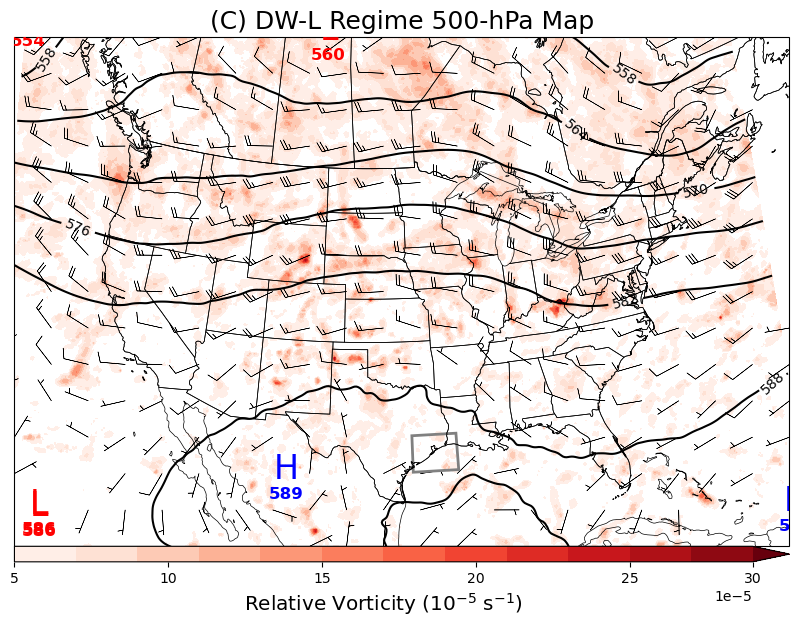

In [44]:
## Make a 500 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
##fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([235., 290., 20., 55.])
##ax.set_extent([-91., -108., 25., 36.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())


lons, lats = dsb1.longitude.values, dsb1.latitude.values

## Get the heights and smooth so that it's not wobbly
gh = (dsb1.gh.values)/10.  ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
cs = ax.contour(lons, lats, gh, levels = np.arange(420, 660, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)

dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
vor_500b1 = dsb1['vorticity'].values
cfv = ax.contourf(lons, lats, vor_500b1, cmap = 'Reds', levels = np.arange(5e-5, 3.01e-4, 20e-6), vmin = 5e-5, vmax = 3e-4, extend = "max",
                 transform = ccrs.PlateCarree())

##(0, 1.01e-4, 1e-6), vmin = 0, vmax = 1e-4
## Calculate and plot vertical vorticity

##w = dsg.w.metpy.quantify()
##cfr = ax.contourf(lons, lats, w.data.magnitude, cmap = 'RdBu', levels = np.arange(-1, 1, 0.01), vmin = -1.0, vmax = 1.01,
    ##              transform = ccrs.PlateCarree())
cb2=fig.colorbar(cfv, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_ticks(np.arange(5e-5, 3.01e-4, 5e-5))
cb2.set_label(r'Relative Vorticity ($10^{-5}$ s$^{-1}$)', size='x-large') 
##cb2.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x * 1e5)))
##cb2.formatter = ticker.ScalarFormatter(useMathText=True)
cb2.formatter.set_scientific(True)
cb2.formatter.set_powerlimits((-5,-5))
cb2.update_ticks()

## Calculate and plot vertical vorticity

##w = dsb1.w.metpy.quantify()
##cfr = ax.contourf(lons, lats, w.data.magnitude, cmap = 'RdBu', levels = np.arange(-1, 1, 0.01), vmin = -1, vmax = 1.1,
                 ## transform = ccrs.PlateCarree())

## Create the colorbar for relative vorticity
##cb2=fig.colorbar(cfr, ax=ax, orientation='horizontal', pad=0, aspect=50)
##cb2.set_label(r'Omega Pa/s', size='x-large')

## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude, v.data.magnitude, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

## for high/low pressure systems
plot_maxmin_points(lons, lats, gh, extrema = 'max', nsize = 50, symbol = 'H', color = 'b',
                   plotValue=False, transform= ccrs.PlateCarree())

plot_maxmin_points(lons, lats, gh, extrema = 'min', nsize = 50, symbol = 'L', color = 'r',
                   plotValue=False, transform= ccrs.PlateCarree())

ax.add_patch(rect)

ax.set_title('(C) DW-L Regime 500-hPa Map',fontsize = 18)
##plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/BothMode1_500_composite_w')
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/BothMode1_500_composite')

In [19]:
## Let's split up the domain wide into the two regimes 
## We'll start with our gulf files
p5 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 2/rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datab2 = xr.open_mfdataset(p5, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 500.0}},
                         combine = 'nested', concat_dim = 'valid_time')

In [20]:
u = datab2.u.metpy.quantify().metpy.convert_units('knot')
v = datab2.v.metpy.quantify().metpy.convert_units('knot')
lons, lats = datab2.longitude.values, datab2.latitude.values
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

vor_500b2 = mpcalc.vorticity(u, v, dx=dx[np.newaxis, :,:], dy=dy[np.newaxis, :, :])
vor_500b2 = vor_500b2.metpy.convert_units('1/s').data.magnitude
vor_500b2[vor_500b2 < 1e-5] = np.nan

dims = ('valid_time', 'y', 'x')
vor_500b2_da = xr.DataArray(vor_500b2, dims=dims, coords  = {
    'valid_time': datab2['valid_time'],
    'y' : datab2['y'],
    'x' : datab2['x']
})

datab2['vorticity'] = vor_500b2_da
dsb2 = datab2.mean(dim='valid_time', keep_attrs = True).load()
vor_500b2


array([[[           nan,            nan,            nan, ...,
         3.72324403e-05, 3.72352347e-05, 3.72375220e-05],
        [           nan,            nan,            nan, ...,
         1.62892644e-05, 1.86165349e-05, 2.79248864e-05],
        [           nan,            nan,            nan, ...,
                    nan, 1.16311605e-05, 1.62852732e-05],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan, 

In [21]:
## Get our u and v data
u = dsb2.u.metpy.quantify().metpy.convert_units('knot')
v = dsb2.v.metpy.quantify().metpy.convert_units('knot')
w = dsb2.w.metpy.quantify()

/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_79903/3132989527.py:23: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter, minimum_filter
/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_79903/3132989527.py:23: DeprecationWarning: Please import `minimum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter, minimum_filter


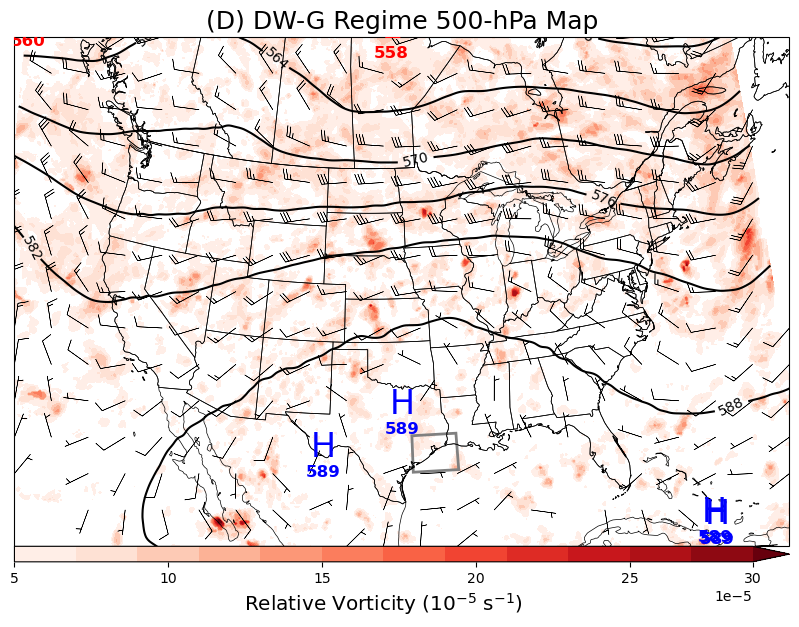

In [24]:
## Make a 500 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
##fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([235., 290., 20., 55.])
##ax.set_extent([-91., -108., 25., 36.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

##small_extent = [-93, -96.5 ,28, 30.5]
##lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())

lons, lats = dsb2.longitude.values, dsb2.latitude.values

## Get the heights and smooth so that it's not wobbly
gh = (dsb2.gh.values)/10.  ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
cs = ax.contour(lons, lats, gh, levels = np.arange(420, 660, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)

## Calculate and plot relative voriticyt 
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
vor_500b2 = dsb2['vorticity'].values
cfv = ax.contourf(lons, lats, vor_500b2, cmap = 'Reds', levels = np.arange(5e-5, 3.01e-4, 20e-6), vmin = 5e-5, vmax = 3e-4, extend = "max",
                 transform = ccrs.PlateCarree())

##(0, 1.01e-4, 1e-6), vmin = 0, vmax = 1e-4
## Calculate and plot vertical vorticity

##w = dsg.w.metpy.quantify()
##cfr = ax.contourf(lons, lats, w.data.magnitude, cmap = 'RdBu', levels = np.arange(-1, 1, 0.01), vmin = -1.0, vmax = 1.01,
    ##              transform = ccrs.PlateCarree())
cb2=fig.colorbar(cfv, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_ticks(np.arange(5e-5, 3.01e-4, 5e-5))
cb2.set_label(r'Relative Vorticity ($10^{-5}$ s$^{-1}$)', size='x-large') 
##cb2.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x * 1e5)))
##cb2.formatter = ticker.ScalarFormatter(useMathText=True)
cb2.formatter.set_scientific(True)
cb2.formatter.set_powerlimits((-5,-5))
cb2.update_ticks()


## Calculate and plot vertical vorticity

##w = dsb2.w.metpy.quantify()
##cfr = ax.contourf(lons, lats, w.data.magnitude, cmap = 'RdBu', levels = np.arange(-1, 1, 0.01), vmin = -1, vmax = 1.1,
                  ##transform = ccrs.PlateCarree())

## Create the colorbar for relative vorticity
##cb2=fig.colorbar(cfr, ax=ax, orientation='horizontal', pad=0, aspect=50)
##cb2.set_label(r'Omega Pa/s', size='x-large')

## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude, v.data.magnitude, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

## for high/low pressure systems
plot_maxmin_points(lons, lats, gh, extrema = 'max', nsize = 50, symbol = 'H', color = 'b',
                   plotValue=False, transform= ccrs.PlateCarree())

plot_maxmin_points(lons, lats, gh, extrema = 'min', nsize = 50, symbol = 'L', color = 'r',
                   plotValue=False, transform= ccrs.PlateCarree())
ax.add_patch(rect)

ax.set_title('(D) DW-G Regime 500-hPa Map',fontsize = 18)
##plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/BothMode2_500_composite_w', dpi=300)
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/BothMode2_500_composite', dpi=300)

/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_2829/3132989527.py:23: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter, minimum_filter
/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_2829/3132989527.py:23: DeprecationWarning: Please import `minimum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter, minimum_filter


Text(0.5, 1.0, '(A) Land Regime 500-hPa Map')

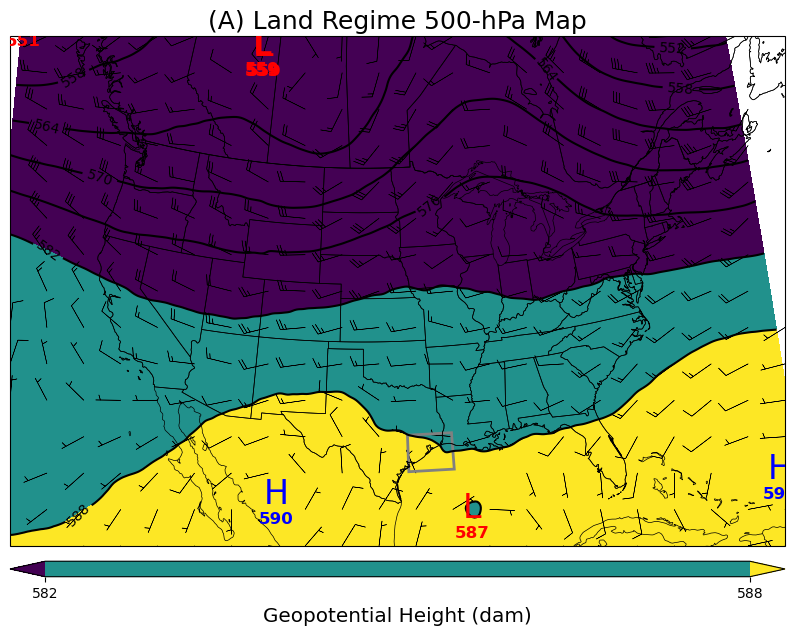

In [10]:
## Make a 500 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
##fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([235., 290., 20., 55.])
##ax.set_extent([-91., -108., 25., 36.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())



lons, lats = dsl.longitude.values, dsl.latitude.values

## Get the heights and smooth so that it's not wobbly
##gh = mpcalc.smooth_gaussian((dsl.gh.values)/10. , 1) ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
gh = (dsl.gh.values)/10.
cs = ax.contour(lons, lats, gh, levels = np.arange(420, 660, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)


## Calculate and plot vertical vorticity

##w = dsl.w.metpy.quantify()
##cfr = ax.contourf(lons, lats, w.data.magnitude, cmap = 'RdBu', levels = np.arange(-1, 1, 0.01), vmin = -1.0, vmax = 1.1,
                 ## transform = ccrs.PlateCarree())

cfgh = ax.contourf(
    lons, lats, gh, 
    cmap='viridis',  # Choose an appropriate colormap for geopotential height
    levels=np.arange(582, 594, 6),  # Use the same levels as for contouring
    extend="both",  # Extend the shading beyond the levels if necessary
    transform=ccrs.PlateCarree()
)

## Add the colorbar for geopotential height
cb_gh = fig.colorbar(cfgh, ax=ax, orientation='horizontal', pad=0.02, aspect=50)
cb_gh.set_label(r'Geopotential Height (dam)', size='x-large')



## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude, v.data.magnitude, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

## for high/low pressure systems
plot_maxmin_points(lons, lats, gh, extrema = 'max', nsize = 50, symbol = 'H', color = 'b',
                   plotValue=False, transform= ccrs.PlateCarree())

plot_maxmin_points(lons, lats, gh, extrema = 'min', nsize = 50, symbol = 'L', color = 'r',
                   plotValue=False, transform= ccrs.PlateCarree())

ax.add_patch(rect)

ax.set_title('(A) Land Regime 500-hPa Map',fontsize = 18)

In [11]:
## Now we can do our 850 mb level plots so we'll use a similar methodology 
## For these plots, we want winds and relative humidity and geopotential heights

## We'll start with gulf again

p = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Gulf_Data/RAP Data/rap_130*.grb2'

## WE want to open our data. This is for the 850 geopotential height level
datag = xr.open_mfdataset(p, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 850.0}},
                         combine = 'nested', concat_dim = 'valid_time')

In [15]:
## we want to create means from all of our RAP data
dsg = datag.mean(dim='valid_time', keep_attrs = True).load()
## Get our u and v data
u = dsg.u.metpy.quantify().metpy.convert_units('knot')
v = dsg.v.metpy.quantify().metpy.convert_units('knot')

In [13]:
np.logical_and( 
                        np.logical_and(dsg.longitude.values <= extent[1], dsg.longitude.values >= extent[0]), 
                        np.logical_and(dsg.latitude.values <= extent[3], dsg.latitude.values >= extent[2]))

NameError: name 'extent' is not defined

In [14]:
dsg_zoom = dsg.where(np.logical_and( 
                        np.logical_and(dsg.longitude.values <= extent[1], dsg.longitude.values >= extent[0]), 
                        np.logical_and(dsg.latitude.values <= extent[3], dsg.latitude.values >= extent[2])))

dsg_zoom.t.plot(x='longitude',y='latitude')

NameError: name 'extent' is not defined

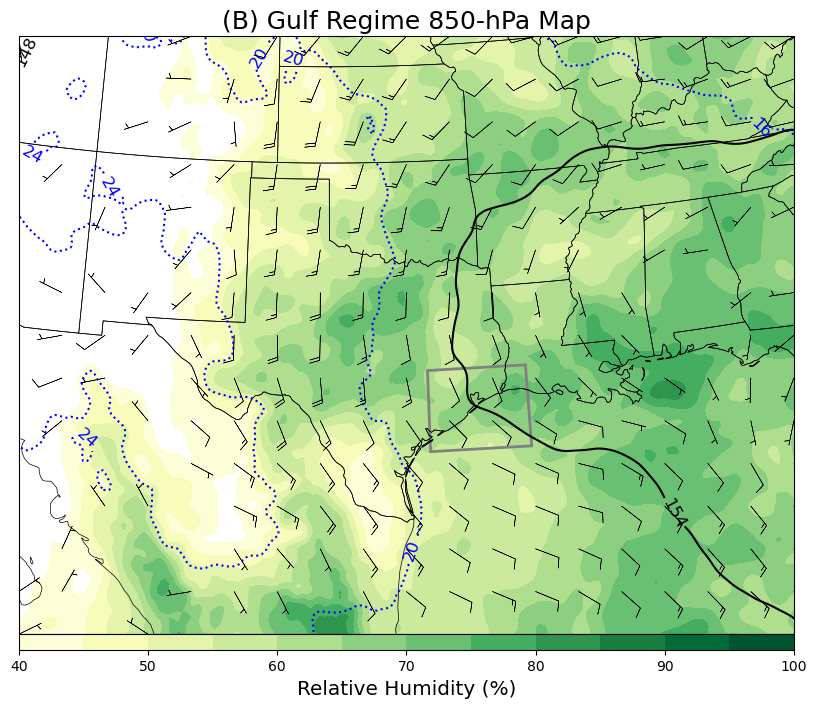

In [33]:
## Make a 850 geopotential heights Map
from matplotlib.ticker import MaxNLocator
## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
extent = [250., 275., 22., 40.]
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())
 
dsg_zoom = dsg.where(np.logical_and( 
                        np.logical_and(dsg.longitude.values <= 280, dsg.longitude.values >= 245), 
                        np.logical_and(dsg.latitude.values <= 41, dsg.latitude.values >= 18)))

lons, lats = dsg_zoom.longitude.values, dsg_zoom.latitude.values

## Get the heights and smooth so that it's not wobbly
gh = (dsg_zoom.gh.values)/10.  ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
cs = ax.contour(lons, lats, gh, levels = np.arange(100, 250, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 

plt.clabel(cs, fontsize=12, inline_spacing=5)
##plt.clabel(cs, fontsize=12, inline_spacing=5)

## Show relative humidity
## For research plot, use 1 for the arange
## For regular plot, use 10
r = dsg_zoom.r.metpy.quantify()
cfr = ax.contourf(lons, lats, r.data.magnitude, cmap = 'YlGn', levels = np.arange(40, 101, 5), vmin = 40, vmax = 101,
                  transform = ccrs.PlateCarree())

cb2=fig.colorbar(cfr, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_label('Relative Humidity (%)', size='x-large')

## Show temperature contours
temp = dsg_zoom.t.metpy.quantify().metpy.convert_units('degC')
plottemp = ax.contour(lons, lats, temp.data.magnitude, levels = np.arange(-40,40,4), vmin = -40, vmax = 40,
             colors='b', linestyles='dotted', transform=ccrs.PlateCarree())
##plt.clabel(plottemp, inline = True, rightside_up = True, use_clabeltext=True, inline_spacing=0.1)

## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude, v.data.magnitude, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)
plt.clabel(plottemp, fmt='%d', inline=True, fontsize=12, inline_spacing = 5, colors='b')
##plt.clabel(plottemp, fmt='%d', inline=True, fontsize=12, inline_spacing = 5, colors='b')
##plt.clabel(plottemp, fmt='%d', inline = True, fontsize=12, inline_spacing = 5, colors='b')


ax.set_title('(B) Gulf Regime 850-hPa Map',fontsize = 18)

##plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/rp_Gulf_850_composite_more_labels.png', dpi=300)
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/rp_Gulf_850_composite.png', dpi=300)

## Note to self: countourf = filled. countour = just lines

In [34]:
## Repeat everything for Land Data
p2 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Land_Data/RAP Files/rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datal = xr.open_mfdataset(p2, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 850.0}},
                         combine = 'nested', concat_dim = 'valid_time')

## we want to create means from all of our RAP data
dsl = datal.mean(dim='valid_time', keep_attrs = True).load()

## Get our u and v data
u = dsl.u.metpy.quantify().metpy.convert_units('knot')
v = dsl.v.metpy.quantify().metpy.convert_units('knot')

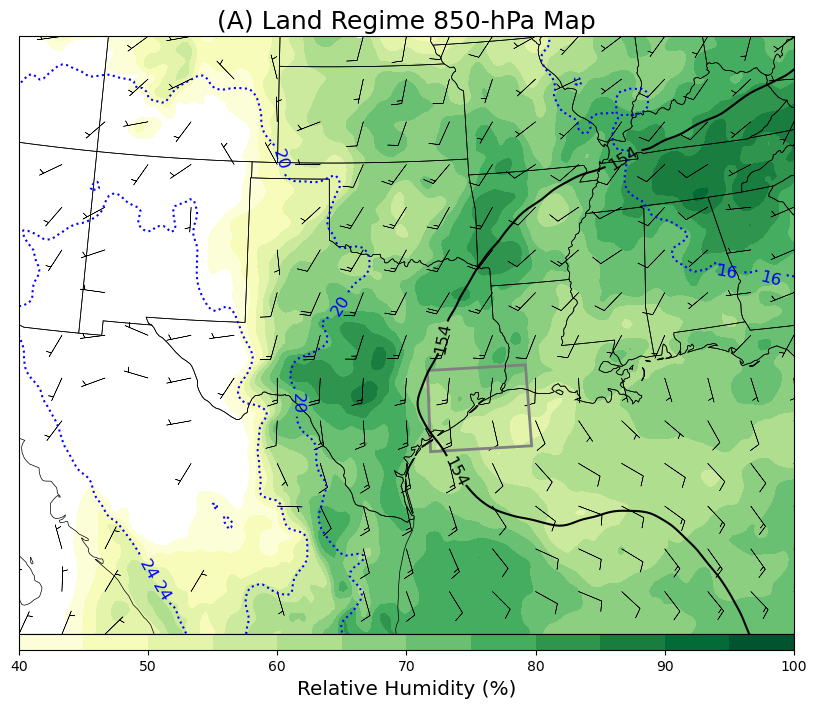

In [37]:
## Make a 850 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
extent = [250., 275., 22., 40.]
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())

dsl_zoom = dsl.where(np.logical_and( 
                        np.logical_and(dsl.longitude.values <= 280, dsl.longitude.values >= 245), 
                        np.logical_and(dsl.latitude.values <= 41, dsl.latitude.values >= 18)))

lons, lats = dsl_zoom.longitude.values, dsl_zoom.latitude.values

## Get the heights and smooth so that it's not wobbly
gh = (dsl_zoom.gh.values)/10.  ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
cs = ax.contour(lons, lats, gh, levels = np.arange(100, 250, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs, fontsize=12, inline_spacing=5)
plt.clabel(cs, fontsize=12, inline_spacing=5)

## Show relative humidity 
r = dsl_zoom.r.metpy.quantify()
cfr = ax.contourf(lons, lats, r.data.magnitude, cmap = 'YlGn', levels = np.arange(40, 101, 5), vmin = 40, vmax = 101,
                  transform = ccrs.PlateCarree())

cb2=fig.colorbar(cfr, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_label('Relative Humidity (%)', size='x-large')

## Show temperature contours
temp = dsl_zoom.t.metpy.quantify().metpy.convert_units('degC')
plottemp = ax.contour(lons, lats, temp.data.magnitude, levels = np.arange(-40,40,4), vmin = -40, vmax = 40,
             colors='b', linestyles='dotted', transform=ccrs.PlateCarree())
##plt.clabel(plottemp)

## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude, v.data.magnitude, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)
## contour labels 
plt.clabel(plottemp, fmt='%d', inline=True, fontsize=12, inline_spacing=5, colors='b')
plt.clabel(plottemp, fmt='%d', inline=True, fontsize=12, inline_spacing=5, colors='b')

ax.set_title('(A) Land Regime 850-hPa Map',fontsize = 18)

##plt.savefig('/apple/s0/kem6245/escape/ESCAPE_Figures/Composite Synoptic/Land_850_composite')
##plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Land_850_composite.png', dpi=300)
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Land_850_composite_more_labels.png', dpi=300)

In [38]:
## Let's split up the domain wide into the two regimes 
## Domain Wide Mode 1
p4 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datab1 = xr.open_mfdataset(p4, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 850.0}},
                         combine = 'nested', concat_dim = 'valid_time')

## we want to create means from all of our RAP data
dsb1 = datab1.mean(dim='valid_time', keep_attrs = True).load()

## Get our u and v data
u = dsb1.u.metpy.quantify().metpy.convert_units('knot')
v = dsb1.v.metpy.quantify().metpy.convert_units('knot')

Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20170602_0600_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20170606_0600_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20170624_0700_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20170630_1300_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20180608_0900_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20180610_0800_000.grb2.9c67f.idx' incompat

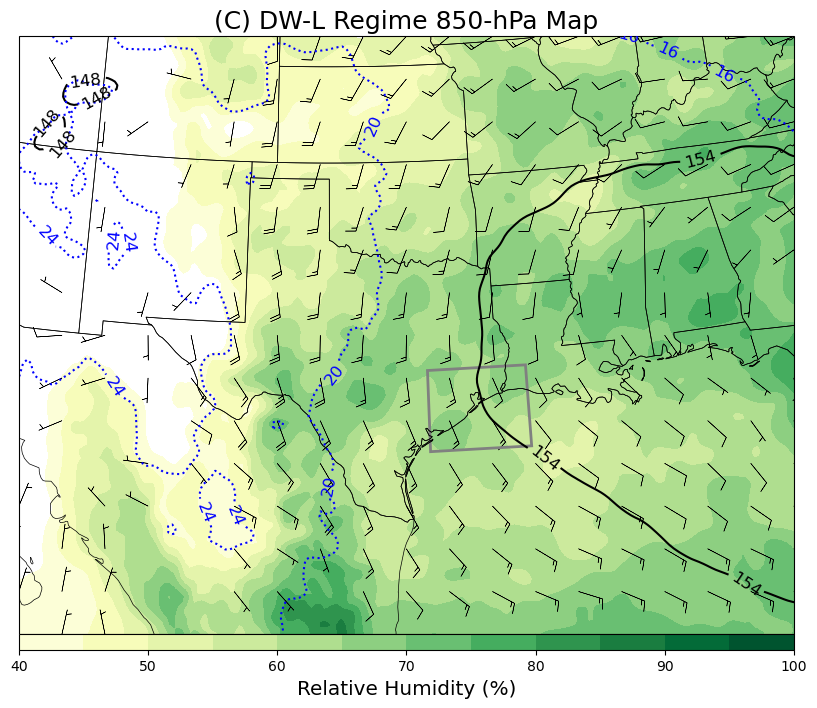

In [40]:
## Make a 850 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
extent = [250., 275., 22., 40.]
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())


dsb1_zoom = dsb1.where(np.logical_and( 
                        np.logical_and(dsb1.longitude.values <= 280, dsb1.longitude.values >= 245), 
                        np.logical_and(dsb1.latitude.values <= 41, dsb1.latitude.values >= 18)))
lons, lats = dsb1_zoom.longitude.values, dsb1_zoom.latitude.values

## Get the heights and smooth so that it's not wobbly
gh = (dsb1_zoom.gh.values)/10. ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
cs = ax.contour(lons, lats, gh, levels = np.arange(100, 250, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs, fontsize=12, inline_spacing = 5)
plt.clabel(cs, fontsize=12, inline_spacing = 5)
## Show relative humidity 
r = dsb1_zoom.r.metpy.quantify()
cfr = ax.contourf(lons, lats, r.data.magnitude, cmap = 'YlGn', levels = np.arange(40, 101, 5), vmin = 40, vmax = 101,
                  transform = ccrs.PlateCarree())

cb2=fig.colorbar(cfr, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_label('Relative Humidity (%)', size='x-large')

## Show temperature contours
temp = dsb1_zoom.t.metpy.quantify().metpy.convert_units('degC')
plottemp = ax.contour(lons, lats, temp.data.magnitude, levels = np.arange(-40,40,4), vmin = -40, vmax = 40,
             colors='b', linestyles='dotted', transform=ccrs.PlateCarree())
plt.clabel(plottemp, fmt='%d', inline=True, fontsize=12, inline_spacing=5, colors='b')
plt.clabel(plottemp, fmt='%d', inline=True, fontsize=12, inline_spacing=5, colors='b')
## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude, v.data.magnitude, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)

ax.set_title('(C) DW-L Regime 850-hPa Map',fontsize = 18)

##plt.savefig('/apple/s0/kem6245/escape/ESCAPE_Figures/Composite Synoptic/Mode1_850_composite')
##plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/rp_Mode1_850_composite.png', dpi=300)
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/rp_Mode1_850_composite_more_labels.png', dpi=300)

In [45]:
## Let's split up the domain wide into the two regimes 
## Domain Wide Mode 1
p5 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 2/rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datab2 = xr.open_mfdataset(p5, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 850.0}},
                         combine = 'nested', concat_dim = 'valid_time')

## we want to create means from all of our RAP data
dsb2 = datab2.mean(dim='valid_time', keep_attrs = True).load()

## Get our u and v data
u = dsb2.u.metpy.quantify().metpy.convert_units('knot')
v = dsb2.v.metpy.quantify().metpy.convert_units('knot')

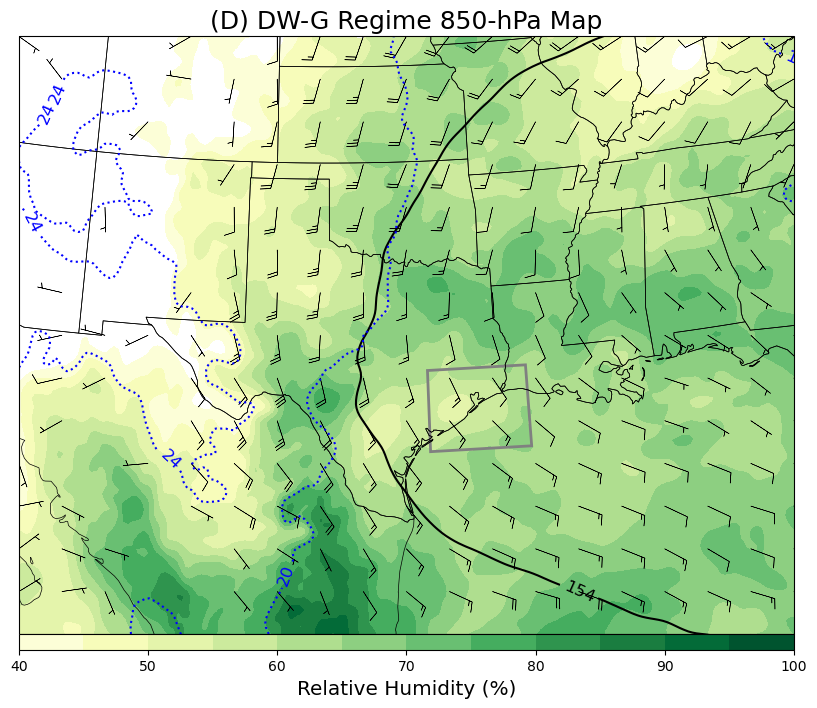

In [60]:
## Make a 850 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
extent = [250., 275., 22., 40.]
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())

dsb2_zoom = dsb2.where(np.logical_and( 
                        np.logical_and(dsb2.longitude.values <= 280, dsb2.longitude.values >= 245), 
                        np.logical_and(dsb2.latitude.values <= 41, dsb2.latitude.values >= 18)))
lons, lats = dsb2_zoom.longitude.values, dsb2_zoom.latitude.values

## Get the heights and smooth so that it's not wobbly
gh = (dsb2_zoom.gh.values)/10. ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
cs = ax.contour(lons, lats, gh, levels = np.arange(100, 250, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs, fontsize=12, inline_spacing = 5)
plt.clabel(cs, fontsize=12, inline_spacing = 5)

## Show relative humidity 
r = dsb2_zoom.r.metpy.quantify()
cfr = ax.contourf(lons, lats, r.data.magnitude, cmap = 'YlGn', levels = np.arange(40, 101, 5), vmin = 40, vmax = 101,
                  transform = ccrs.PlateCarree())

cb2=fig.colorbar(cfr, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_label('Relative Humidity (%)', size='x-large')

## Show temperature contours
temp = dsb2_zoom.t.metpy.quantify().metpy.convert_units('degC')
plottemp = ax.contour(lons, lats, temp.data.magnitude, levels = np.arange(-40,40,4), vmin = -40, vmax = 40,
             colors='b', linestyles='dotted', transform=ccrs.PlateCarree())
##plt.clabel(plottemp, fmt='%d', inline=True, fontsize=12, inline_spacing=5, colors='b')
##plt.clabel(plottemp, fmt='%d', inline=True, fontsize=12, inline_spacing=5, colors='b')
plt.clabel(plottemp, fontsize=12, inline_spacing = 5)
plt.clabel(plottemp, fontsize=12, inline_spacing = 5)
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/rp_Mode2_850_composite.png', dpi=300)

## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude, v.data.magnitude, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)

ax.set_title('(D) DW-G Regime 850-hPa Map',fontsize = 18)

##plt.savefig('/apple/s0/kem6245/escape/ESCAPE_Figures/Composite Synoptic/Mode2_850_composite')
##plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/rp_Mode2_850_composite.png', dpi=300)
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/rp_Mode2_850_composite_more_labels.png', dpi=300)

In [20]:
## Now it's time for 250 level maps

## We'll start with gulf again

p = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Gulf_Data/RAP Data/rap_130*.grb2'

## WE want to open our data. This is for the 850 geopotential height level
datag = xr.open_mfdataset(p, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 250.0}},
                         combine = 'nested', concat_dim = 'valid_time').load()
## Get our u and v data
u = datag.u.metpy.quantify().metpy.convert_units('knot')
v = datag.v.metpy.quantify().metpy.convert_units('knot')
speed = mpcalc.wind_speed(u, v)
lons, lats = datag.longitude.values, datag.latitude.values

## Get the heights and smooth so that it's not wobbly
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
div = mpcalc.divergence(u, v, dx=dx[np.newaxis, :,:], dy=dy[np.newaxis, :,:])
div = div.metpy.convert_units('1/s').data.magnitude
datag['speed'] = speed

dims = ('valid_time', 'y', 'x')
div_da = xr.DataArray(div, dims=dims, coords  = {
    'valid_time': datag['valid_time'],
    'y' : datag['y'],
    'x' : datag['x']
})

datag['divergence'] = div_da
dsg = datag.mean(dim='valid_time', keep_attrs = True).load()

## Get our u and v data
##u = dsl.u.metpy.quantify().metpy.convert_units('knot')
##v = dsl.v.metpy.quantify().metpy.convert_units('knot')

dsg['u']
dsg['v']




<xarray.DataArray 'v' (y: 337, x: 451)> Size: 608kB
array([[ 2.668863  ,  2.762613  ,  2.8928213 , ..., -0.8832204 ,
        -0.6488454 , -0.31551203],
       [ 2.762613  ,  2.856363  ,  2.9865713 , ..., -0.9769704 ,
        -0.737387  , -0.4040537 ],
       [ 2.8771963 ,  2.965738  ,  3.0803213 , ..., -1.0394703 ,
        -0.7894704 , -0.4821787 ],
       ...,
       [-2.1332204 , -2.1488454 , -2.159262  , ...,  1.7417797 ,
         2.1115713 ,  2.496988  ],
       [-1.9613453 , -1.9769703 , -2.0082204 , ...,  1.7521963 ,
         2.121988  ,  2.496988  ],
       [-1.8207203 , -1.8675953 , -1.8988453 , ...,  1.7469879 ,
         2.121988  ,  2.4761546 ]], dtype=float32)
Coordinates:
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 250.0
    latitude       (y, x) float64 1MB 16.28 16.31 16.34 ... 55.54 55.51 55.48
    longitude      (y, x) float64 1MB 233.9 234.0 234.1 ... 302.3 302.4 302.6
  * y              (y) int64 3kB 0 1 2 3 4 5 6 7 ... 330 331 332 333 334 335 336
  * x              (x) int64 4kB 0 1 2 3 4 5 6 7 ... 444 445 446 447 448 449 450
Attributes: (12/33)
    GRIB_paramId:                             132
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      151987
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                V component of wind
    GRIB_shortName:                           v
    GRIB_units:                               m s**-1
    long_name:                                V component of wind
    units:                                    m s**-1
    standard_name:                            northward_wind

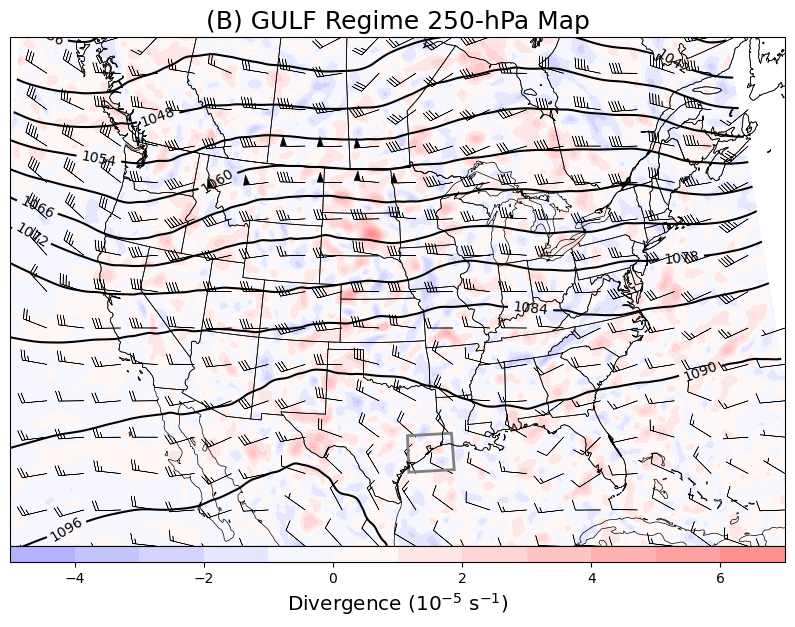

In [24]:
## Make a 250 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([235., 290., 20., 55.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())


lons, lats = dsg.longitude.values, dsg.latitude.values

## Get the heights and smooth so that it's not wobbly
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
gh = (dsg.gh.values)/10.  ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
cs = ax.contour(lons, lats, gh, levels = np.arange(1000, 1200, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)

## Show divergence
div = dsg['divergence'].values
##div_plot = ax.contour(lons, lats, div*1e5, levels = np.arange(-7,8,3), colors = 'r', transform = ccrs.PlateCarree())
plt.clabel(div_plot)
                      ##levels = np.arange(1000, 1200, 6), colors = 'k', transform = ccrs.PlateCarree())
##speed = mpcalc.wind_speed(u, v)
##speed_data = dsg['speed'].values
##wind = np.arange(20, 250, 20)
##windjet = ax.contourf(lons, lats, speed_data, wind, cmap=plt.cm.BuPu, levels = np.arange(20, 65, 5), vmin = 20, vmax = 65,
                  ##transform = ccrs.PlateCarree(), extend = "max")
    
divshade = ax.contourf(lons, lats, div * 1e5, cmap=plt.cm.bwr, levels = np.arange(-5,8,1), vmin = -15, vmax = 15, transform = ccrs.PlateCarree())
cb2 = fig.colorbar(divshade, ax=ax, orientation = 'horizontal', pad = 0, aspect = 50, extend = "both")
## Create the colorbar for relative vorticity
##cb2=fig.colorbar(windjet, ax=ax, orientation='horizontal', pad=0, aspect=50, extend = "right")
##cb2.set_label('Wind Speed (kts)', size='x-large')
cb2.set_label('Divergence ($10^{-5}$ s$^{-1}$)', size='x-large')

u = dsg.u.metpy.quantify().metpy.convert_units('knot')
v = dsg.v.metpy.quantify().metpy.convert_units('knot')

## u and v windbarbs
ax.barbs(lons, lats, u, v, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)

ax.set_title('(B) GULF Regime 250-hPa Map',fontsize = 18)

##plt.savefig('/apple/s0/kem6245/escape/ESCAPE_Figures/Composite Synoptic/Gulf_250_composite')
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Gulf_250_composite.png', dpi=300)

## Note to self: countourf = filled. countour = just lines

In [25]:
## Repeat everything for Land Data
p2 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Land_Data/RAP Files/rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datal = xr.open_mfdataset(p2, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 250.0}},
                         combine = 'nested', concat_dim = 'valid_time').load()
## Get our u and v data
u = datal.u.metpy.quantify().metpy.convert_units('knot')
v = datal.v.metpy.quantify().metpy.convert_units('knot')
speed = mpcalc.wind_speed(u, v)
datal['speed'] = speed

lons, lats = datal.longitude.values, datal.latitude.values

## Get the heights and smooth so that it's not wobbly
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
div = mpcalc.divergence(u, v, dx=dx[np.newaxis, :,:], dy=dy[np.newaxis, :,:])
div = div.metpy.convert_units('1/s').data.magnitude
datal['speed'] = speed

dims = ('valid_time', 'y', 'x')
div_da = xr.DataArray(div, dims=dims, coords  = {
    'valid_time': datal['valid_time'],
    'y' : datal['y'],
    'x' : datal['x']
})

datal['divergence'] = div_da
dsl = datal.mean(dim='valid_time', keep_attrs = True).load()

## Get our u and v data
##u = dsl.u.metpy.quantify().metpy.convert_units('knot')
##v = dsl.v.metpy.quantify().metpy.convert_units('knot')

dsg['u']
dsg['v']


<xarray.DataArray 'v' (y: 337, x: 451)> Size: 608kB
array([[ 2.668863  ,  2.762613  ,  2.8928213 , ..., -0.8832204 ,
        -0.6488454 , -0.31551203],
       [ 2.762613  ,  2.856363  ,  2.9865713 , ..., -0.9769704 ,
        -0.737387  , -0.4040537 ],
       [ 2.8771963 ,  2.965738  ,  3.0803213 , ..., -1.0394703 ,
        -0.7894704 , -0.4821787 ],
       ...,
       [-2.1332204 , -2.1488454 , -2.159262  , ...,  1.7417797 ,
         2.1115713 ,  2.496988  ],
       [-1.9613453 , -1.9769703 , -2.0082204 , ...,  1.7521963 ,
         2.121988  ,  2.496988  ],
       [-1.8207203 , -1.8675953 , -1.8988453 , ...,  1.7469879 ,
         2.121988  ,  2.4761546 ]], dtype=float32)
Coordinates:
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 250.0
    latitude       (y, x) float64 1MB 16.28 16.31 16.34 ... 55.54 55.51 55.48
    longitude      (y, x) float64 1MB 233.9 234.0 234.1 ... 302.3 302.4 302.6
  * y              (y) int64 3kB 0 1 2 3 4 5 6 7 ... 330 331 332 333 334 335 336
  * x              (x) int64 4kB 0 1 2 3 4 5 6 7 ... 444 445 446 447 448 449 450
Attributes: (12/33)
    GRIB_paramId:                             132
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      151987
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                V component of wind
    GRIB_shortName:                           v
    GRIB_units:                               m s**-1
    long_name:                                V component of wind
    units:                                    m s**-1
    standard_name:                            northward_wind

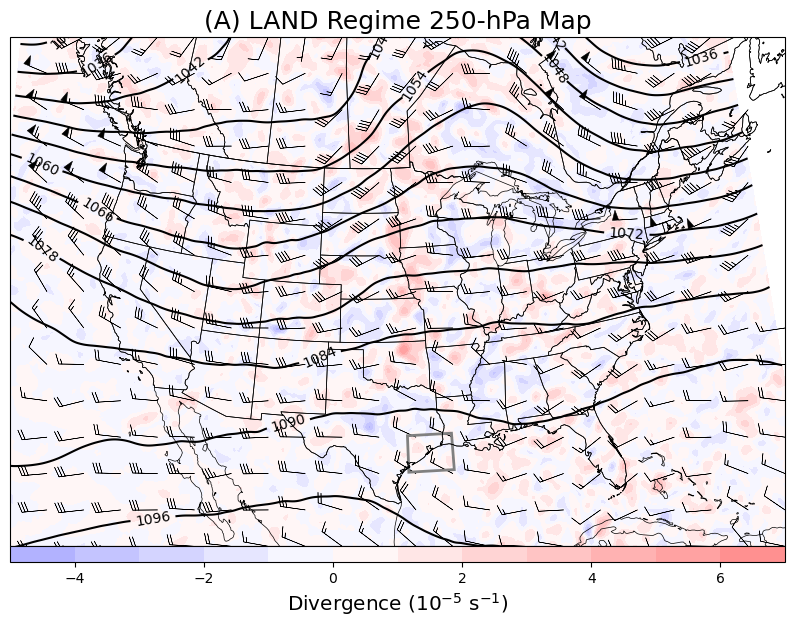

In [27]:
## Make a 250 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([235., 290., 20., 55.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())


lons, lats = dsl.longitude.values, dsl.latitude.values

## Get the heights and smooth so that it's not wobbly
gh = (dsl.gh.values)/10. ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
cs = ax.contour(lons, lats, gh, levels = np.arange(1000, 1200, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)

## Show divergence
## Show divergence
div = dsl['divergence'].values
    
divshade = ax.contourf(lons, lats, div * 1e5, cmap=plt.cm.bwr, levels = np.arange(-5,8,1), vmin = -15, vmax = 15, transform = ccrs.PlateCarree())
cb2 = fig.colorbar(divshade, ax=ax, orientation = 'horizontal', pad = 0, aspect = 50, extend = "both")
## Create the colorbar for relative vorticity
cb2.set_label('Divergence ($10^{-5}$ s$^{-1}$)', size='x-large')
##speed_data = dsl['speed'].values

##print(speed)
##wind = np.arange(20, 250, 20)
##windjet = ax.contourf(lons, lats, speed_data, wind, cmap=plt.cm.BuPu, levels = np.arange(10, 70, 10), vmin = 20, vmax = 65,
                 ## transform = ccrs.PlateCarree(), extend = "max")
## Create the colorbar for relative vorticity
##cb2=fig.colorbar(windjet, ax=ax, orientation='horizontal', pad=0, aspect=50, extend = "max")
##cb2.set_label('Wind Speed (kts)', size='x-large')

u = dsl.u.metpy.quantify().metpy.convert_units('knot')
v = dsl.v.metpy.quantify().metpy.convert_units('knot')
## u and v windbarbs
ax.barbs(lons, lats, u, v, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)

ax.set_title('(A) LAND Regime 250-hPa Map',fontsize = 18)

plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Land_250_composite.png', dpi=300)

## Note to self: countourf = filled. countour = just lines

In [29]:
## Let's split up the domain wide into the two regimes 
## Domain Wide Mode 1
p4 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datab1 = xr.open_mfdataset(p4, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 250.0}},
                         combine = 'nested', concat_dim = 'valid_time').load()

## Get our u and v data
u = datab1.u.metpy.quantify().metpy.convert_units('knot')
v = datab1.v.metpy.quantify().metpy.convert_units('knot')
speed = mpcalc.wind_speed(u, v)
datab1['speed'] = speed


lons, lats = datab1.longitude.values, datab1.latitude.values

## Get the heights and smooth so that it's not wobbly
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
div = mpcalc.divergence(u, v, dx=dx[np.newaxis, :,:], dy=dy[np.newaxis, :,:])
div = div.metpy.convert_units('1/s').data.magnitude
datab1['speed'] = speed

dims = ('valid_time', 'y', 'x')
div_da = xr.DataArray(div, dims=dims, coords  = {
    'valid_time': datab1['valid_time'],
    'y' : datab1['y'],
    'x' : datab1['x']
})

datab1['divergence'] = div_da
dsb1 = datab1.mean(dim='valid_time', keep_attrs = True).load()

## Get our u and v data
##u = dsl.u.metpy.quantify().metpy.convert_units('knot')
##v = dsl.v.metpy.quantify().metpy.convert_units('knot')

dsb1['u']
dsb1['v']


Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20170602_0600_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20170606_0600_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20170624_0700_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20170630_1300_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20180608_0900_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130_20180610_0800_000.grb2.9c67f.idx' incompat

<xarray.DataArray 'v' (y: 337, x: 451)> Size: 608kB
array([[ 1.6932571,  1.6675217,  1.63811  , ..., -3.8949783, -3.814096 ,
        -3.729537 ],
       [ 1.6969335,  1.6638453,  1.6417865, ..., -3.98689  , -3.902331 ,
        -3.8251252],
       [ 1.6895806,  1.6675217,  1.645463 , ..., -4.086155 , -3.9979193,
        -3.9207134],
       ...,
       [ 7.476345 ,  7.5131097,  7.4984035, ...,  2.722669 ,  2.707963 ,
         2.6895807],
       [ 7.553551 ,  7.6086984,  7.593992 , ...,  2.6417866,  2.63811  ,
         2.6086981],
       [ 7.63811  ,  7.6822276,  7.6895804, ...,  2.57561  ,  2.5719335,
         2.5461981]], dtype=float32)
Coordinates:
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 250.0
    latitude       (y, x) float64 1MB 16.28 16.31 16.34 ... 55.54 55.51 55.48
    longitude      (y, x) float64 1MB 233.9 234.0 234.1 ... 302.3 302.4 302.6
  * y              (y) int64 3kB 0 1 2 3 4 5 6 7 ... 330 331 332 333 334 335 336
  * x              (x) int64 4kB 0 1 2 3 4 5 6 7 ... 444 445 446 447 448 449 450
Attributes: (12/33)
    GRIB_paramId:                             132
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      151987
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                V component of wind
    GRIB_shortName:                           v
    GRIB_units:                               m s**-1
    long_name:                                V component of wind
    units:                                    m s**-1
    standard_name:                            northward_wind

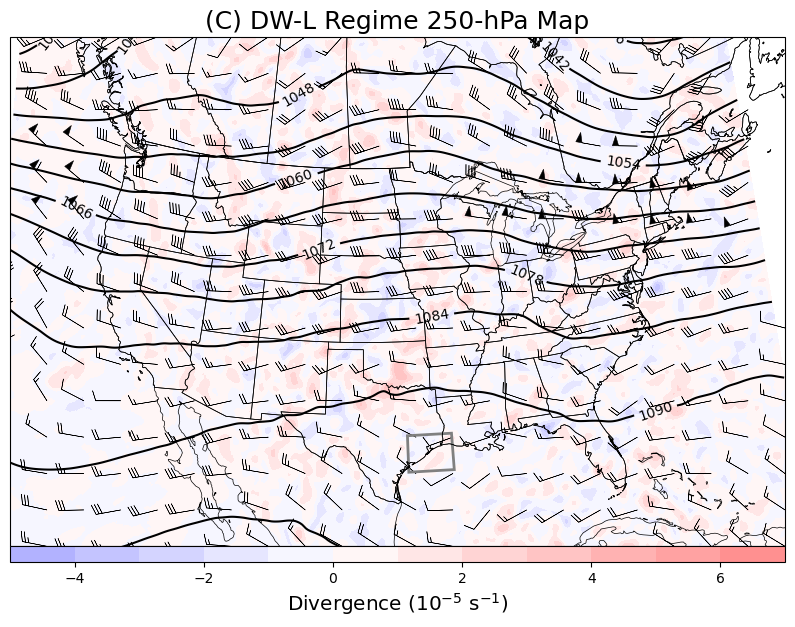

In [30]:
## Make a 250 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([235., 290., 20., 55.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())


lons, lats = dsb1.longitude.values, dsb1.latitude.values

## Get the heights and smooth so that it's not wobbly
gh = (dsb1.gh.values)/10. ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
cs = ax.contour(lons, lats, gh, levels = np.arange(1000, 1200, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)

## Show divergence
div = dsb1['divergence'].values
    
divshade = ax.contourf(lons, lats, div * 1e5, cmap=plt.cm.bwr,levels = np.arange(-5,8,1), vmin = -15, vmax = 15, transform = ccrs.PlateCarree())
cb2 = fig.colorbar(divshade, ax=ax, orientation = 'horizontal', pad = 0, aspect = 50, extend = "both")
## Create the colorbar for relative vorticity
cb2.set_label('Divergence ($10^{-5}$ s$^{-1}$)', size='x-large')
##speed_data = dsb1['speed'].values
##speed = mpcalc.wind_speed(u, v)
##wind = np.arange(20, 250, 20)
##windjet = ax.contourf(lons, lats, speed_data, wind, cmap=plt.cm.BuPu, levels = np.arange(10, 70, 10), vmin = 20, vmax = 65,
                 ## transform = ccrs.PlateCarree(), extend = "max")
## Original range: 20, 65, 5
## Create the colorbar for relative vorticity
##cb2=fig.colorbar(windjet, ax=ax, orientation='horizontal', pad=0, aspect=50, extend = "max")
##cb2.set_label('Wind Speed (kts)', size='x-large')

u = dsb1.u.metpy.quantify().metpy.convert_units('knot')
v = dsb1.v.metpy.quantify().metpy.convert_units('knot')
## u and v windbarbs
ax.barbs(lons, lats, u, v, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)

ax.set_title('(C) DW-L Regime 250-hPa Map',fontsize = 18)

plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Mode1_250_composite.png', dpi=300)

In [31]:
## Let's split up the domain wide into the two regimes 
## Domain Wide Mode 2
p5 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 2/rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datab2 = xr.open_mfdataset(p5, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 250.0}},
                         combine = 'nested', concat_dim = 'valid_time').load()

## Get our u and v data
u = datab2.u.metpy.quantify().metpy.convert_units('knot')
v = datab2.v.metpy.quantify().metpy.convert_units('knot')
speed = mpcalc.wind_speed(u, v)
datab2['speed'] = speed


lons, lats = datab2.longitude.values, datab2.latitude.values

## Get the heights and smooth so that it's not wobbly
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
div = mpcalc.divergence(u, v, dx=dx[np.newaxis, :,:], dy=dy[np.newaxis, :,:])
div = div.metpy.convert_units('1/s').data.magnitude
datab2['speed'] = speed

dims = ('valid_time', 'y', 'x')
div_da = xr.DataArray(div, dims=dims, coords  = {
    'valid_time': datab2['valid_time'],
    'y' : datab2['y'],
    'x' : datab2['x']
})

datab2['divergence'] = div_da
dsb2 = datab2.mean(dim='valid_time', keep_attrs = True).load()

## Get our u and v data
##u = dsl.u.metpy.quantify().metpy.convert_units('knot')
##v = dsl.v.metpy.quantify().metpy.convert_units('knot')

dsb2['u']
dsb2['v']

<xarray.DataArray 'v' (y: 337, x: 451)> Size: 608kB
array([[ 1.7333351 ,  1.8750018 ,  2.0000017 , ..., -1.1249983 ,
        -1.1958317 , -1.2749983 ],
       [ 1.570835  ,  1.7125018 ,  1.8291684 , ..., -1.1083317 ,
        -1.1874983 , -1.2583317 ],
       [ 1.4250016 ,  1.558335  ,  1.6750017 , ..., -1.116665  ,
        -1.1874983 , -1.2708317 ],
       ...,
       [-0.14583181, -0.00833181,  0.13333486, ...,  6.587501  ,
         6.975001  ,  7.329169  ],
       [ 0.02916819,  0.14166819,  0.2791682 , ...,  6.687501  ,
         7.095835  ,  7.450002  ],
       [ 0.1916682 ,  0.30000153,  0.4291682 , ...,  6.800001  ,
         7.2166686 ,  7.604169  ]], dtype=float32)
Coordinates:
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 250.0
    latitude       (y, x) float64 1MB 16.28 16.31 16.34 ... 55.54 55.51 55.48
    longitude      (y, x) float64 1MB 233.9 234.0 234.1 ... 302.3 302.4 302.6
  * y              (y) int64 3kB 0 1 2 3 4 5 6 7 ... 330 331 332 333 334 335 336
  * x              (x) int64 4kB 0 1 2 3 4 5 6 7 ... 444 445 446 447 448 449 450
Attributes: (12/33)
    GRIB_paramId:                             132
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      151987
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                V component of wind
    GRIB_shortName:                           v
    GRIB_units:                               m s**-1
    long_name:                                V component of wind
    units:                                    m s**-1
    standard_name:                            northward_wind

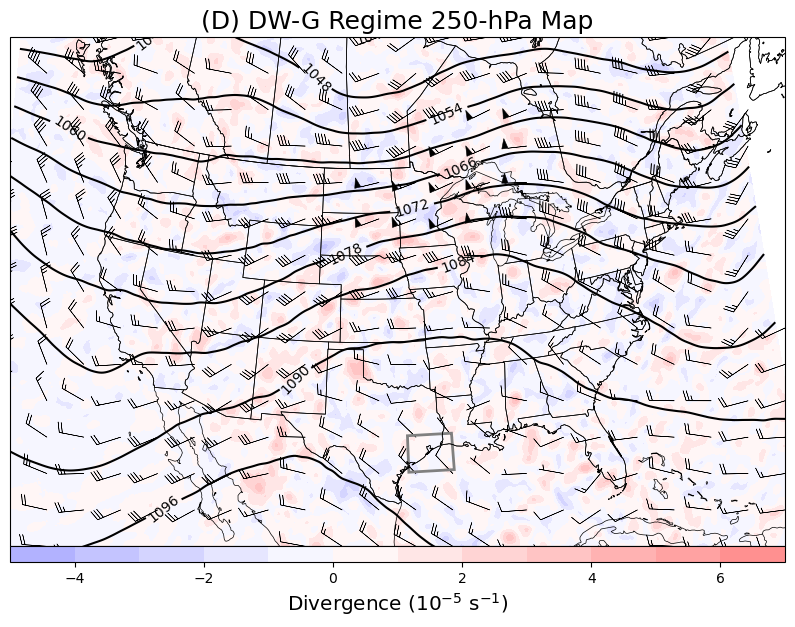

In [32]:
## Make a 250 geopotential heights Map

## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([235., 290., 20., 55.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())


lons, lats = dsb2.longitude.values, dsb2.latitude.values

## Get the heights and smooth so that it's not wobbly
gh = (dsb2.gh.values)/10. ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
cs = ax.contour(lons, lats, gh, levels = np.arange(1000, 1200, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)

## Show divergence
div = dsb2['divergence'].values
    
divshade = ax.contourf(lons, lats, div * 1e5, cmap=plt.cm.bwr,levels = np.arange(-5,8,1), vmin = -15, vmax = 15, transform = ccrs.PlateCarree())
cb2 = fig.colorbar(divshade, ax=ax, orientation = 'horizontal', pad = 0, aspect = 50, extend = "both")
## Create the colorbar for relative vorticity
cb2.set_label('Divergence ($10^{-5}$ s$^{-1}$)', size='x-large')
##speed = mpcalc.wind_speed(u, v)
##speed_data = dsb2['speed'].values
##wind = np.arange(20, 250, 20)
##windjet = ax.contourf(lons, lats, speed_data, wind, cmap=plt.cm.BuPu, levels = np.arange(10, 70, 10), vmin = 20, vmax = 65,
                  ##transform = ccrs.PlateCarree(), extend = "max")
## Create the colorbar for relative vorticity
##cb2=fig.colorbar(windjet, ax=ax, orientation='horizontal', pad=0, aspect=50, extend = "max")
##cb2.set_label('Wind Speed (kts)', size='x-large')

u = dsb2.u.metpy.quantify().metpy.convert_units('knot')
v = dsb2.v.metpy.quantify().metpy.convert_units('knot')

## u and v windbarbs
ax.barbs(lons, lats, u, v, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)

ax.set_title('(D) DW-G Regime 250-hPa Map',fontsize = 18)

plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Mode2_250_composite.png', dpi=300)

In [16]:
## This is a test to try and find 10 m winds
p = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Gulf_Data/RAP Data/rap_130*.grb2'

##, backend_kwargs={'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'surface'}}

datag = xr.open_mfdataset(p, engine = 'cfgrib', backend_kwargs = {'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'pressureFromGroundLayer'}},
                        combine = 'nested', concat_dim = 'valid_time').load()
dataga = xr.open_mfdataset(p, engine = 'cfgrib', backend_kwargs={'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'meanSea'}},
                        combine = 'nested', concat_dim = 'valid_time').load()

dsg = datag.mean(dim='valid_time', keep_attrs = True).load()
dsga = dataga.mean(dim='valid_time', keep_attrs = True).load()


## Dataga = the surface pressure
## Datag = other surface variables
## we want to create means from all of our RAP data

press = dsga.mslma.metpy.quantify().metpy.convert_units('hPa')

## Now we want our variables for our other units, but only the surface
temp = dsg.t.metpy.quantify().metpy.convert_units('degC')
rh = dsg.r.metpy.quantify()
## Get our u and v data
u = dsg.u.metpy.quantify().metpy.convert_units('knot')
v = dsg.v.metpy.quantify().metpy.convert_units('knot')
## Us the original maps

skipping variable: paramId==260128 shortName='lftx4'
Traceback (most recent call last):
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 701, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 629, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='pressureFromGroundLayer' value=Variable(dimensions=('pressureFromGroundLayer',), data=array([ 3000.,  6000.,  9000., 12000., 15000., 18000.])) new_value=Variable(dimensions=(), data=18000.0)
skipping variable: paramId==59 shortName='cape'
Traceback (most recent call last):
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 701, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/kem6245/anaconda3/

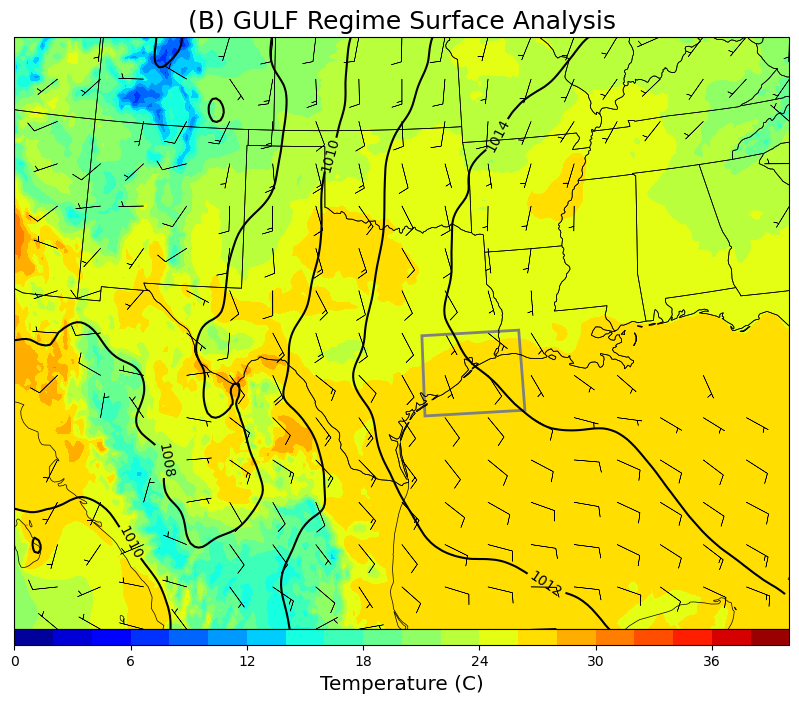

In [17]:
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([250., 275., 21., 39.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())

dsga_zoom = dsga.where(np.logical_and( 
                        np.logical_and(dsga.longitude.values <= 275, dsga.longitude.values >= 248), 
                        np.logical_and(dsga.latitude.values <= 41, dsga.latitude.values >= 18)))

lonsa, latsa = dsga_zoom.longitude.values, dsga_zoom.latitude.values
lons, lats = dsg.longitude.values, dsg.latitude.values
press = dsga_zoom.mslma.metpy.quantify().metpy.convert_units('hPa')


## Get the heights and smooth so that it's not wobbly
press_plot = press
cs = ax.contour(lonsa, latsa, press_plot, levels = np.arange(990, 1020, 2), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)

## do the same thing for temperatures
##temp_plot = mpcalc.smooth_gaussian(temp.data.magnitude[0], 20)
##ts = ax.contour(lons, lats, temp_plot, levels = np.arange(0, 41, 2), colors = 'r', vmin = 0, vmax = 40, transform = ccrs.PlateCarree())
##plt.clabel(ts)

## do the same thing for temperatures
temp_plot = temp.data.magnitude[0]
ts = ax.contourf(lons, lats, temp_plot, levels = np.arange(0, 41, 2), cmap = 'jet', vmin = 0, vmax = 40, transform = ccrs.PlateCarree())

cb2=fig.colorbar(ts, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_label('Temperature (C)', size='x-large')

## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude[0], v.data.magnitude[0], regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)

## contour labels 
##plt.clabel(cs, fmt='%d', inline=True, fontsize=10, inline_spacing=5, colors='black')

ax.set_title('(B) GULF Regime Surface Analysis',fontsize = 18)

##plt.savefig('/apple/s0/kem6245/escape/ESCAPE_Figures/Composite Synoptic/Gulf_surface_analysis')

plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Gulf_surface_analysis_shaded')

In [5]:
## Land
p1 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Land_Data/RAP Files/rap_130*.grb2'

##, backend_kwargs={'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'surface'}}

datal = xr.open_mfdataset(p1, engine = 'cfgrib', backend_kwargs = {'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'pressureFromGroundLayer'}},
                        combine = 'nested', concat_dim = 'valid_time')
datala = xr.open_mfdataset(p1, engine = 'cfgrib', backend_kwargs={'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'meanSea'}},
                        combine = 'nested', concat_dim = 'valid_time')

## we want to create means from all of our RAP data
dsl = datal.mean(dim='valid_time', keep_attrs = True).load()
dsla = datala.mean(dim='valid_time', keep_attrs = True).load()

press = dsla.mslma.metpy.quantify().metpy.convert_units('hPa')

## Now we want our variables for our other units, but only the surface
temp = dsl.t.metpy.quantify().metpy.convert_units('degC')
rh = dsl.r.metpy.quantify()
## Get our u and v data
u = dsl.u.metpy.quantify().metpy.convert_units('knot')
v = dsl.v.metpy.quantify().metpy.convert_units('knot')

skipping variable: paramId==260128 shortName='lftx4'
Traceback (most recent call last):
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 701, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 629, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='pressureFromGroundLayer' value=Variable(dimensions=('pressureFromGroundLayer',), data=array([ 3000.,  6000.,  9000., 12000., 15000., 18000.])) new_value=Variable(dimensions=(), data=18000.0)
skipping variable: paramId==59 shortName='cape'
Traceback (most recent call last):
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 701, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/kem6245/anaconda3/

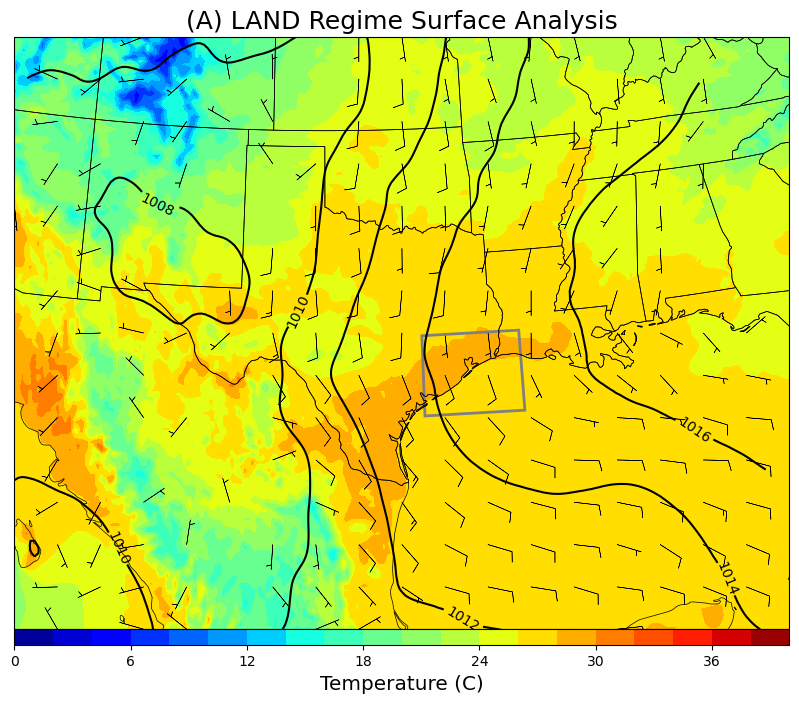

In [6]:
## First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([250., 275., 21., 39.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())

dsla_zoom = dsla.where(np.logical_and( 
                        np.logical_and(dsla.longitude.values <= 275, dsla.longitude.values >= 248), 
                        np.logical_and(dsla.latitude.values <= 41, dsla.latitude.values >= 18)))

lonsa, latsa = dsla_zoom.longitude.values, dsla_zoom.latitude.values
lons, lats = dsl.longitude.values, dsl.latitude.values
press = dsla_zoom.mslma.metpy.quantify().metpy.convert_units('hPa')


## Get the heights and smooth so that it's not wobbly
press_plot = press
cs = ax.contour(lonsa, latsa, press_plot, levels = np.arange(990, 1020, 2), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)

## do the same thing for temperatures
##temp_plot = mpcalc.smooth_gaussian(temp.data.magnitude[0], 20)
##ts = ax.contour(lons, lats, temp_plot, levels = np.arange(0, 41, 2), colors = 'r', vmin = 0, vmax = 40, transform = ccrs.PlateCarree())
##plt.clabel(ts)

## do the same thing for temperatures
temp_plot = temp.data.magnitude[0]
ts = ax.contourf(lons, lats, temp_plot, levels = np.arange(0, 41, 2), cmap = 'jet', vmin = 0, vmax = 40, transform = ccrs.PlateCarree())

cb2=fig.colorbar(ts, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_label('Temperature (C)', size='x-large')

## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude[0], v.data.magnitude[0], regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)

## contour labels 
##plt.clabel(cs, fmt='%d', inline=True, fontsize=10, inline_spacing=5, colors='black')

ax.set_title('(A) LAND Regime Surface Analysis',fontsize = 18)

##plt.savefig('/apple/s0/kem6245/escape/ESCAPE_Figures/Composite Synoptic/Land_surface_analysis')
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Land_surface_analysis_shaded')

In [7]:
## Both Mode 1
p3 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130*.grb2'

##, backend_kwargs={'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'surface'}}

datab1 = xr.open_mfdataset(p3, engine = 'cfgrib', backend_kwargs = {'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'pressureFromGroundLayer'}},
                        combine = 'nested', concat_dim = 'valid_time')
datab1a = xr.open_mfdataset(p3, engine = 'cfgrib', backend_kwargs={'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'meanSea'}},
                        combine = 'nested', concat_dim = 'valid_time')

## we want to create means from all of our RAP data
dsb1 = datab1.mean(dim='valid_time', keep_attrs = True).load()
dsb1a = datab1a.mean(dim='valid_time', keep_attrs = True).load()

press = dsb1a.mslma.metpy.quantify().metpy.convert_units('hPa')

## Now we want our variables for our other units, but only the surface
temp = dsb1.t.metpy.quantify().metpy.convert_units('degC')
rh = dsb1.r.metpy.quantify()
## Get our u and v data
u = dsb1.u.metpy.quantify().metpy.convert_units('knot')
v = dsb1.v.metpy.quantify().metpy.convert_units('knot')

skipping variable: paramId==260128 shortName='lftx4'
Traceback (most recent call last):
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 701, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 629, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='pressureFromGroundLayer' value=Variable(dimensions=('pressureFromGroundLayer',), data=array([ 3000.,  6000.,  9000., 12000., 15000., 18000.])) new_value=Variable(dimensions=(), data=18000.0)
skipping variable: paramId==59 shortName='cape'
Traceback (most recent call last):
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 701, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/kem6245/anaconda3/

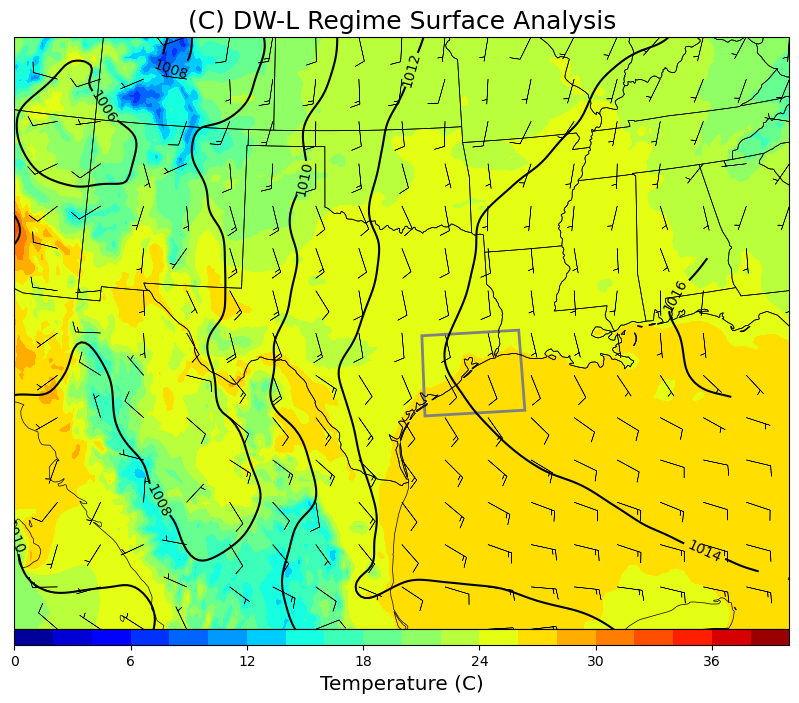

In [8]:
# First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([250., 275., 21., 39.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())

dsb1a_zoom = dsb1a.where(np.logical_and( 
                        np.logical_and(dsb1a.longitude.values <= 275, dsb1a.longitude.values >= 245), 
                        np.logical_and(dsb1a.latitude.values <= 41, dsb1a.latitude.values >= 18)))

lonsa, latsa = dsb1a_zoom.longitude.values, dsb1a_zoom.latitude.values
lons, lats = dsb1.longitude.values, dsb1.latitude.values
press = dsb1a_zoom.mslma.metpy.quantify().metpy.convert_units('hPa')


lons, lats = dsb1.longitude.values, dsb1.latitude.values
lonsa, latsa = dsb1a.longitude.values, dsb1a.latitude.values

## Get the heights and smooth so that it's not wobbly
press_plot = mpcalc.smooth_gaussian(press, 10)
cs = ax.contour(lonsa, latsa, press_plot, levels = np.arange(990, 1020, 2), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)

## do the same thing for temperatures
##temp_plot = mpcalc.smooth_gaussian(temp.data.magnitude[0], 20)
##ts = ax.contour(lons, lats, temp_plot, levels = np.arange(0, 41, 2), colors = 'r', vmin = 0, vmax = 40, transform = ccrs.PlateCarree())
##plt.clabel(ts)

## do the same thing for temperatures
temp_plot = mpcalc.smooth_gaussian(temp.data.magnitude[0], 1)
ts = ax.contourf(lons, lats, temp_plot, levels = np.arange(0, 41, 2), cmap = 'jet', vmin = 0, vmax = 40, transform = ccrs.PlateCarree())

cb2=fig.colorbar(ts, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_label('Temperature (C)', size='x-large')

## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude[0], v.data.magnitude[0], regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)
## contour labels 
##plt.clabel(cs, fmt='%d', inline=True, fontsize=10, inline_spacing=5, colors='black')

ax.set_title('(C) DW-L Regime Surface Analysis',fontsize = 18)

##plt.savefig('/apple/s0/kem6245/escape/ESCAPE_Figures/Composite Synoptic/Both_Mode1_surface_analysis')
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Both_Mode1_surface_analysis_shaded')

In [9]:
## Both Mode 2
p4 = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 2/rap_130*.grb2'

##, backend_kwargs={'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'surface'}}

datab2 = xr.open_mfdataset(p4, engine = 'cfgrib', backend_kwargs = {'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'pressureFromGroundLayer'}},
                        combine = 'nested', concat_dim = 'valid_time')
datab2a = xr.open_mfdataset(p4,engine = 'cfgrib', backend_kwargs={'filter_by_keys':{'stepType': 'instant', 'typeOfLevel': 'meanSea'}},
                           combine = 'nested', concat_dim = 'valid_time')

## we want to create means from all of our RAP data
dsb2 = datab2.mean(dim='valid_time', keep_attrs = True).load()
dsb2a = datab2a.mean(dim='valid_time', keep_attrs = True).load()

press = dsb2a.mslma.metpy.quantify().metpy.convert_units('hPa')
print(press)
## Now we want our variables for our other units, but only the surface
temp = dsb2.t.metpy.quantify().metpy.convert_units('degC')
rh = dsb2.r.metpy.quantify()
## Get our u and v data
u = dsb2.u.metpy.quantify().metpy.convert_units('knot')
v = dsb2.v.metpy.quantify().metpy.convert_units('knot')

skipping variable: paramId==260128 shortName='lftx4'
Traceback (most recent call last):
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 701, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 629, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='pressureFromGroundLayer' value=Variable(dimensions=('pressureFromGroundLayer',), data=array([ 3000.,  6000.,  9000., 12000., 15000., 18000.])) new_value=Variable(dimensions=(), data=18000.0)
skipping variable: paramId==59 shortName='cape'
Traceback (most recent call last):
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 701, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/kem6245/anaconda3/

<xarray.DataArray 'mslma' (y: 337, x: 451)> Size: 608kB
<Quantity([[1013.93585 1013.9205  1013.90717 ... 1015.70044 1015.7165  1015.73047]
 [1013.9978  1013.98175 1013.9678  ... 1015.7585  1015.7718  1015.78516]
 [1014.0585  1014.0425  1014.0278  ... 1015.81647 1015.8278  1015.8391 ]
 ...
 [1016.12177 1016.1045  1016.09045 ... 1012.7091  1012.70514 1012.70044]
 [1016.0638  1016.0505  1016.0391  ... 1012.72046 1012.7138  1012.70715]
 [1016.0091  1015.9985  1015.9872  ... 1012.72516 1012.71716 1012.70776]], 'hectopascal')>
Coordinates:
    step       timedelta64[ns] 8B 00:00:00
    meanSea    float64 8B 0.0
    latitude   (y, x) float64 1MB 16.28 16.31 16.34 16.36 ... 55.54 55.51 55.48
    longitude  (y, x) float64 1MB 233.9 234.0 234.1 234.2 ... 302.3 302.4 302.6
Dimensions without coordinates: y, x
Attributes: (12/32)
    GRIB_paramId:                             260323
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      151987
    GRIB_typeOf

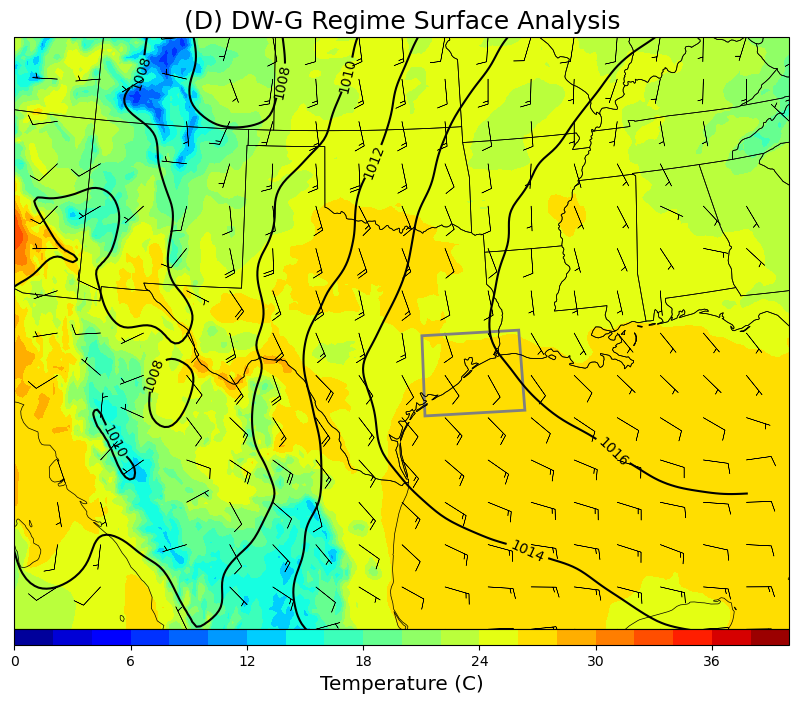

In [10]:
# First we need to define our coordinate system and add all our map features
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([250., 275., 21., 39.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())


dsb2a_zoom = dsb2a.where(np.logical_and( 
                        np.logical_and(dsb2a.longitude.values <= 275, dsb2a.longitude.values >= 245), 
                        np.logical_and(dsb2a.latitude.values <= 41, dsb2a.latitude.values >= 18)))

lonsa, latsa = dsb2a_zoom.longitude.values, dsb2a_zoom.latitude.values
lons, lats = dsb2.longitude.values, dsb2.latitude.values
press = dsb2a_zoom.mslma.metpy.quantify().metpy.convert_units('hPa')

## Get the heights and smooth so that it's not wobbly
press_plot = mpcalc.smooth_gaussian(press, 10)
cs = ax.contour(lonsa, latsa, press_plot, levels = np.arange(990, 1020, 2), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
plt.clabel(cs)

## do the same thing for temperatures
##temp_plot = mpcalc.smooth_gaussian(temp.data.magnitude[0], 20)
##ts = ax.contour(lons, lats, temp_plot, levels = np.arange(0, 41, 2), colors = 'r', vmin = 0, vmax = 40, transform = ccrs.PlateCarree())
##plt.clabel(ts)

## do the same thing for temperatures
temp_plot = mpcalc.smooth_gaussian(temp.data.magnitude[0], 1)
ts = ax.contourf(lons, lats, temp_plot, levels = np.arange(0, 41, 2), cmap = 'jet', vmin = 0, vmax = 40, transform = ccrs.PlateCarree())

cb2=fig.colorbar(ts, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_label('Temperature (C)', size='x-large')

## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude[0], v.data.magnitude[0], regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)
## contour labels 
##plt.clabel(cs, fmt='%d', inline=True, fontsize=10, inline_spacing=5, colors='black')

ax.set_title('(D) DW-G Regime Surface Analysis',fontsize = 18)
##plt.savefig('/apple/s0/kem6245/escape/ESCAPE_Figures/Composite Synoptic/Both_Mode2_surface_analysis')
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/Both_Mode2_surface_analysis_shaded')

In [ ]:
## We're trying something new here to try and plot the omega for the reviewer
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt

gulf = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Gulf_Data/RAP Data/rap_130*.grb2'
land = 
dwl = 
dwg = 
file_list = glob.glob(file_dir)

datasets = [xr.open_dataset(f, engine= 'cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'}) for f in file_list]
datasets_surface = [xr.open_dataset(f, engine='cfgrib', filter_by_keys={'stepType': 'instant','typeOfLevel': 'pressureFromGroundLayer'}) for f in file_list]


datasets_surface
omega_surface = datasets_surface[0]['w']

omega_profiles = [ds['w'] for ds in datasets]

omega_stacked = np.stack([omega.values for omega in omega_profiles], axis = 0)
surface_pressure = 1013

omega = datasets[0]['w']
mean_omega = np.mean(omega_stacked, axis = 0)
iqr_omega = np.percentile(omega_stacked, [25, 75], axis=0)

i_min, i_max = 235, 265
j_min, j_max = 65, 100

omega_box = omega[:, i_min:i_max, j_min:j_max].values
omega_surface_box = omega_surface[i_min:i_max, j_min:j_max].values
omega_box_mean = omega_box.mean(axis=(1,2))
omega_box_iqr = np.percentile(omega_box, [25,75], axis=(1,2))
omega_surface_iqr = np.percentile(omega_surface_box, [25, 75])

omega_surface_mean = omega_surface_box.mean()  # Mean surface omega
omega_box_mean = np.append(omega_surface_mean, omega_box_mean)

combined_iqr_lower = np.array([omega_box_iqr[0], omega_surface_iqr[0]])  # Lower bounds
combined_iqr_upper = np.array([omega_box_iqr[1], omega_surface_iqr[1]])

press = datasets[0]['isobaricInhPa'].values

pressure = np.append(surface_pressure, press)

plt.figure(figsize=(8,6))
plt.plot(omega_box_mean, pressure, label='Mean Omega', color='blue')
plt.fill_betweenx(pressure, combined_iqr_lower, combined_iqr_upper, color='lightblue', alpha=0.5, label = 'IQR')
plt.gca().invert_yaxis()

plt.xlabel('Omega (Pa s$^{-1}$)')
plt.ylabel('Pressure (hPa)')
plt.title('Vertical Omega Profile for GULF Regime')
plt.legend()
plt.grid(True)




skipping variable: paramId==3041 shortName='absv'
Traceback (most recent call last):
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 701, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/kem6245/anaconda3/envs/SynopticEnvironment/lib/python3.11/site-packages/cfgrib/dataset.py", line 629, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,
        775.,  750.,  725.,  700.,  675.,  650.,  625.,  600.,  575.,
        550.,  525.,  500.,  475.,  450.,  425.,  400.,  375.,  350.,
        325.,  300.,  275.,  250.,  225.,  200.,  175.,  150.,  125.,
        100.])) new_value=Variable(dimensions=(), data=500.0)
skipping variable: paramId==3041 shortName='absv'
Traceback (most recent call last):


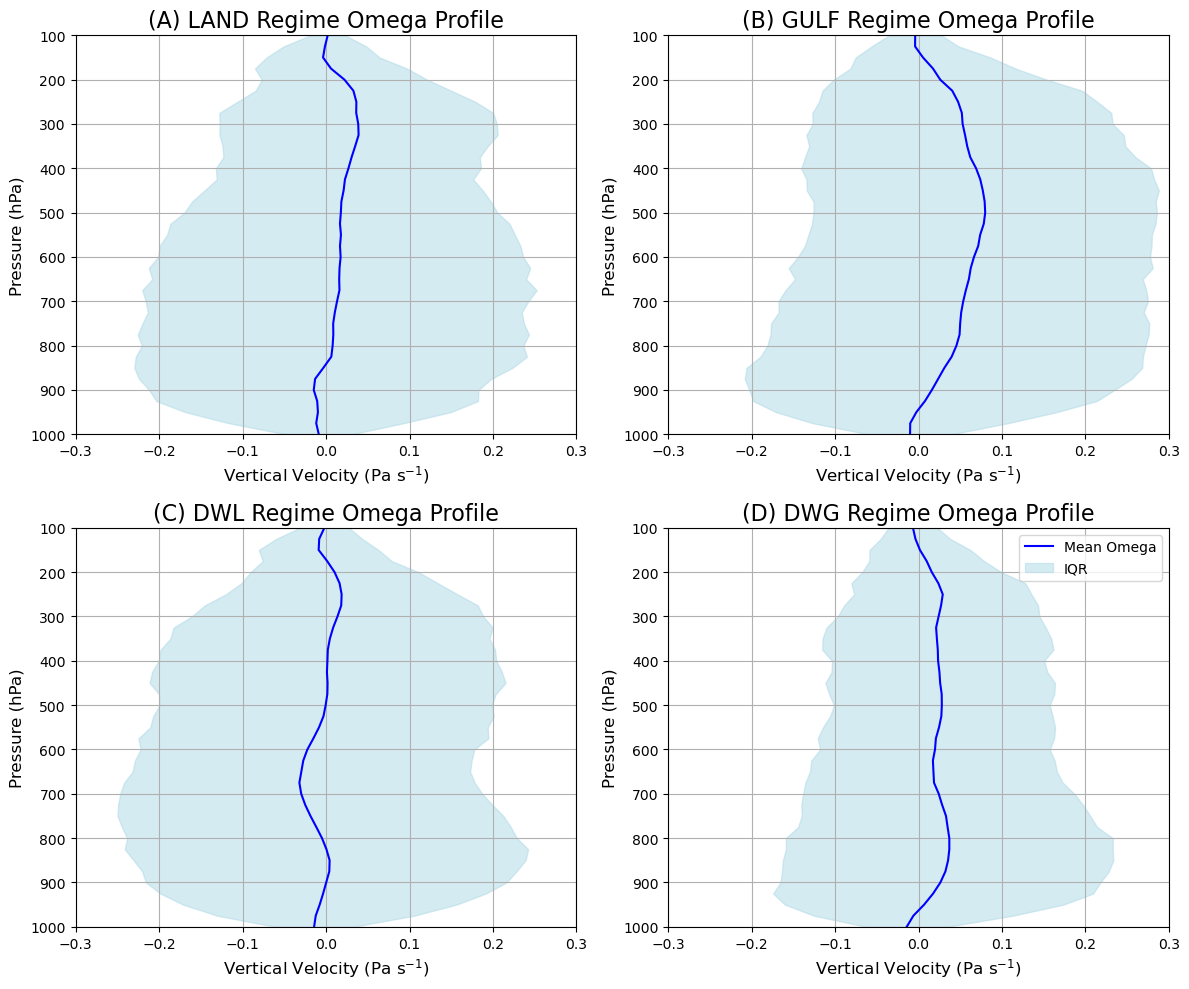

In [1]:
## Take two of this
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt

land = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Land_Data/RAP Files/rap_130*.grb2'
gulf = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Gulf_Data/RAP Data/rap_130*.grb2'
dwl = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 1/rap_130*.grb2'
dwg = '/Users/kem6245/Documents/Python Copy/ESCAPE/RAP_Data/Both_Data/RAP Data/Mode 2/rap_130*.grb2'

lon_slice = slice(235, 265)
lat_slice = slice(65, 100)

directories = [land, gulf, dwl, dwg]


titles = ['(A) LAND Regime Omega Profile', '(B) GULF Regime Omega Profile', '(C) DWL Regime Omega Profile', '(D) DWG Regime Omega Profile']

fig, axs = plt.subplots(2,2, figsize = (12,10))

for idx, directory in enumerate(directories):
    file_list = glob.glob(directory)

    if not file_list:
        print(f"Dumbass, no files found. Skipping")
        continue

    data = [xr.open_dataset(f, engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'}) for f in file_list]

    omega_means = []
    omega_iqrs = []

    for ds in data:
        omega_box = ds['w'].sel(x=lon_slice, y=lat_slice)
        omega_mean = omega_box.mean(dim=['x','y'])
        omega_means.append(omega_mean)

        omega_q1 = omega_box.quantile(0.25, dim=['x','y'])
        omega_q3 = omega_box.quantile(0.75, dim=['x','y'])
        omega_iqr = omega_q3-omega_q1
        omega_iqrs.append(omega_iqr)
    
    pressure = data[0]['isobaricInhPa']

    omega_avg = np.mean(omega_means, axis = 0)
    iqr_avg = np.mean(omega_iqrs, axis = 0)

    iqr_up = omega_avg + iqr_avg
    iqr_low = omega_avg - iqr_avg

    ax = axs[idx // 2, idx % 2]

    ax.plot(omega_avg, pressure, label='Mean Omega', color='blue')

    ax.fill_betweenx(pressure, iqr_low, iqr_up, color='lightblue', alpha=0.5, label='IQR')
    ax.invert_yaxis()

    ax.set_ylim(1000, pressure.min())
    ax.set_xlim(-0.3, 0.3)

    ax.set_title(titles[idx], fontsize = 16)

    ax.set_xlabel('Vertical Velocity (Pa s$^{-1}$)', fontsize = 12)
    ax.set_ylabel('Pressure (hPa)', fontsize = 12)
    ax.grid(True)

plt.tight_layout()
plt.legend()
plt.savefig('/Users/kem6245/Documents/Python Copy/ESCAPE/ESCAPE_Figures/Paper 1/omega_vertical_profiles', dpi=300)